# NLP - Word Embeddings

## Exploración preliminar

Descomentar las siguientes líneas en caso de necesitar instalar estos prerrequisitos en el entorno dde ejecución:

In [ ]:
#!pip install gensim
!pip install fasttext
#!pip install tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296188 sha256=7ab29d6aeca7161bd64509f7855956e8c0e63958a12bbcae53073dce8cc7f6ef
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [ ]:
import gensim.downloader as api
import fasttext
import fasttext.util
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import logging
import os
import seaborn as sns
import gdown
import pickle
import plotly.express as px
import time

from tqdm import tqdm
from wordcloud import WordCloud
from scipy.spatial.distance import cosine
from pathlib import Path
from sklearn.metrics import pairwise
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.callbacks import CallbackAny2Vec


### Gensim

**Gensim** es una biblioteca de Python diseñada para el modelado de temas y el procesamiento de texto no estructurado.   
Es especialmente conocida por su capacidad para manejar grandes corpus de texto y por implementar algoritmos de aprendizaje no supervisado, como Word2Vec, Doc2Vec, y LDA (Latent Dirichlet Allocation), entre otros.  

<br>

*Modelos de Embeddings*:   
Gensim permite crear representaciones vectoriales de palabras y documentos mediante modelos como:  

* Word2Vec: Para generar embeddings de palabras utilizando las arquitecturas CBOW y Skip-gram.
* FastText: Extensión de Word2Vec que tiene en cuenta subpalabras, útil para lenguajes con variaciones morfológicas.
* Doc2Vec: Similar a Word2Vec, pero genera vectores para documentos enteros.

<br>

*Modelado de Temas*:   
Gensim incluye implementaciones de modelos para descubrir temas en colecciones de texto, como:

* LDA: Utilizado para modelar tópicos y encontrar la distribución de palabras en cada tema.
* LSI (Latent Semantic Indexing): Método para reducir la dimensionalidad del texto.


### Embeddings

Un vector de embeddings es una representación matemática de una palabra, frase, o incluso un documento, en un espacio vectorial de dimensiones reducidas.   
Este tipo de representación permite capturar las relaciones semánticas y contextuales entre los términos.   
En lugar de representar las palabras como entradas discretas (por ejemplo, usando un índice en un diccionario), los embeddings las convierten en vectores numéricos que pueden ser manipulados matemáticamente.  


La relación entre los embeddings y la similaridad semántica radica en que palabras o frases que son similares en significado tienden a estar cerca unas de otras en este espacio vectorial.

In [ ]:
# Obtener la información de Gensim
info = api.info()

# Convertir a un DataFrame
models = pd.DataFrame(info['models'])
display(models)

fasttext-wiki-news-subwords-300  \
num_records                                               999999   
file_size                                             1005007116   
base_dataset   Wikipedia 2017, UMBC webbase corpus and statmt...   
reader_code    https://github.com/RaRe-Technologies/gensim-da...   
license          https://creativecommons.org/licenses/by-sa/3.0/   
parameters                                    {'dimension': 300}   
description    1 million word vectors trained on Wikipedia 20...   
read_more      [https://fasttext.cc/docs/en/english-vectors.h...   
checksum                        de2bb3a20c46ce65c9c131e1ad9a77af   
file_name                     fasttext-wiki-news-subwords-300.gz   
parts                                                          1   
preprocessing                                                NaN   

                                conceptnet-numberbatch-17-06-300  \
num_records                                              1917247   
file_size                                             1225497562   
base_dataset   ConceptNet, word2vec, GloVe, and OpenSubtitles...   
reader_code    https://github.com/RaRe-Technologies/gensim-da...   
license        https://github.com/commonsense/conceptnet-numb...   
parameters                                    {'dimension': 300}   
description    ConceptNet Numberbatch consists of state-of-th...   
read_more      [http://aaai.org/ocs/index.php/AAAI/AAAI17/pap...   
checksum                        fd642d457adcd0ea94da0cd21b150847   
file_name                    conceptnet-numberbatch-17-06-300.gz   
parts                                                          1   
preprocessing                                                NaN   

                                         word2vec-ruscorpora-300  \
num_records                                               184973   
file_size                                              208427381   
base_dataset          Russian National Corpus (about 250M words)   
reader_code    https://github.com/RaRe-Technologies/gensim-da...   
license        https://creativecommons.org/licenses/by/4.0/de...   
parameters                 {'dimension': 300, 'window_size': 10}   
description    Word2vec Continuous Skipgram vectors trained o...   
read_more      [https://www.academia.edu/24306935/WebVectors_...   
checksum                        9bdebdc8ae6d17d20839dd9b5af10bc4   
file_name                             word2vec-ruscorpora-300.gz   
parts                                                          1   
preprocessing  The corpus was lemmatized and tagged with Univ...   

                                        word2vec-google-news-300  \
num_records                                              3000000   
file_size                                             1743563840   
base_dataset               Google News (about 100 billion words)   
reader_code    https://github.com/RaRe-Technologies/gensim-da...   
license                                                not found   
parameters                                    {'dimension': 300}   
description    Pre-trained vectors trained on a part of the G...   
read_more      [https://code.google.com/archive/p/word2vec/, ...   
checksum                        a5e5354d40acb95f9ec66d5977d140ef   
file_name                            word2vec-google-news-300.gz   
parts                                                          1   
preprocessing                                                NaN   

                                          glove-wiki-gigaword-50  \
num_records                                               400000   
file_size                                               69182535   
base_dataset    Wikipedia 2014 + Gigaword 5 (6B tokens, uncased)   
reader_code    https://github.com/RaRe-Technologies/gensim-da...   
license                http://opendatacommons.org/licenses/pddl/   
parameters                                     {'dimension': 50}   
description    Pr

### Técnicas para generar embeddings de palabras

|* | [GloVe](https://nlp.stanford.edu/projects/glove/) (Global Vectors for Word Representation) | [FastText](https://fasttext.cc/) |
|-----|-----|-----|
| Descripción | GloVe es un modelo de representación de palabras basado en matrices de coocurrencia. <br> <br>Se basa en la idea de que la frecuencia con la que las palabras aparecen juntas en un corpus de texto refleja sus similitudes semánticas.  <br> <br>Se construye una matriz de coocurrencia que cuenta cuántas veces aparecen las palabras juntas en un contexto determinado. <br>  <br>| FastText es un modelo desarrollado por Facebook que mejora el enfoque de Word2Vec.   <br>  <br>A diferencia de otros métodos que consideran palabras como unidades indivisibles,  FastText representa <br>cada palabra como la suma de los vectores de sus subpalabras (n-gramas). <br> <br> Esto permite que el modelo capture información sobre la morfología de las palabras. |
| Características | GloVe genera vectores de palabras que capturan relaciones semánticas y sintácticas.  <br>  <br> La ventaja es que se pueden representar relaciones de analogía, como "rey - hombre + mujer = reina". <br> <br>  | FastText es especialmente útil para lenguajes con mucha variación morfológica  <br>o para vocabularios que contienen palabras raras o desconocidas.   <br> <br> Al usar subpalabras, puede generar embeddings para palabras no vistas basándose en sus componentes.   <br> <br> |
| Usos |  - GloVe es eficaz cuando se tiene un corpus amplio y denso en términos de coocurrencia de palabras,  <br>ya que se basa en la matriz de coocurrencia.    <br> <br>- Si las palabras en el corpus no cambian mucho y tienen significados bien definidos, GloVe puede ser una buena opción.    <br><br> - Si se requiere captar relaciones semánticas complejas, como analogías  <br>(por ejemplo, "hombre" es a "mujer" como "rey" es a "reina"),  GloVe puede ofrecer buenos resultados.  <br> <br> |  - Si se trabaja con lenguas que tienen mucha variación morfológica o si el corpus incluye muchas palabras raras o técnicas,  <br>FastText es más adecuado porque puede generar embeddings para palabras no vistas.    <br> <br>- Cuando se necesita entender la composición de las palabras y cómo se relacionan sus partes,  <br>FastText es útil porque considera n-gramas.    <br> <br>- Para tareas que requieren un alto nivel de detalle en el significado (como clasificación de texto o análisis de sentimientos),  <br>FastText puede ofrecer mejores resultados gracias a su capacidad para manejar variaciones morfológicas. <br> <br>|
| Resumen |Si se busca capturar relaciones semánticas entre palabras en un contexto amplio  <br>y las palabras son mayormente fijas, GloVe puede ser la mejor opción. <br> <br>| FastText será más adecuado si el corpus tiene una alta variabilidad y se necesita manejar palabras no vistas.|


Ejemplo comparativo modelos Glove de dimensión 50 y 200:

In [ ]:
results = []
glove_models = [m for m in models.columns if m.startswith("glove") and ("50" in m or "200" in m)]

# Modelos preentrenados glove
for model_name in tqdm(glove_models, desc="Cargando modelos GloVe", unit="modelo"):

  # Cargar el modelo con gensim.downloader
  glove_model =  api.load(model_name)

  # Tamaño del vocabulario
  vocab_size = len(glove_model.key_to_index)

  # Primeras 10 palabras del vocabulario
  sample_words = list(glove_model.key_to_index.keys())[:10]

  # Vector de una palabra específica
  word_vector = glove_model['excellent']

  # Palabras similares a 'good'
  similar_words = glove_model.most_similar('good', topn=10)

  # Ejemplo de cálculo de similaridad entre dos palabras
  similarity = glove_model.similarity('good', 'excellent')

  results.append(
      [model_name, # model_name
        vocab_size, # vocabulary_size
        sample_words, # sample_words
        similar_words, # similar_words
        similarity, # similarity
        glove_model.vector_size, # vector_size
        ]
  )

Cargando modelos GloVe:   0%|          | 0/4 [00:00<?, ?modelo/s]

[==================================================] 100.0% 66.0/66.0MB downloaded


Cargando modelos GloVe:  25%|██▌       | 1/4 [01:03<03:11, 63.83s/modelo]

[==================================================] 100.0% 252.1/252.1MB downloaded


Cargando modelos GloVe:  50%|█████     | 2/4 [03:52<04:11, 125.79s/modelo]

[==================================================] 100.0% 199.5/199.5MB downloaded


Cargando modelos GloVe:  75%|███████▌  | 3/4 [06:10<02:10, 130.96s/modelo]

[==================================================] 100.0% 758.5/758.5MB downloaded


Cargando modelos GloVe: 100%|██████████| 4/4 [14:26<00:00, 216.56s/modelo]


In [ ]:
columns = ['Model Name', 'Vocabulary Size', 'Sample Words', 'Similar Words (good)', 'Similarity (good, excellent)', 'Vector Size']
results_df = pd.DataFrame(results, columns=columns)
display(results_df.style.hide(axis='index'))

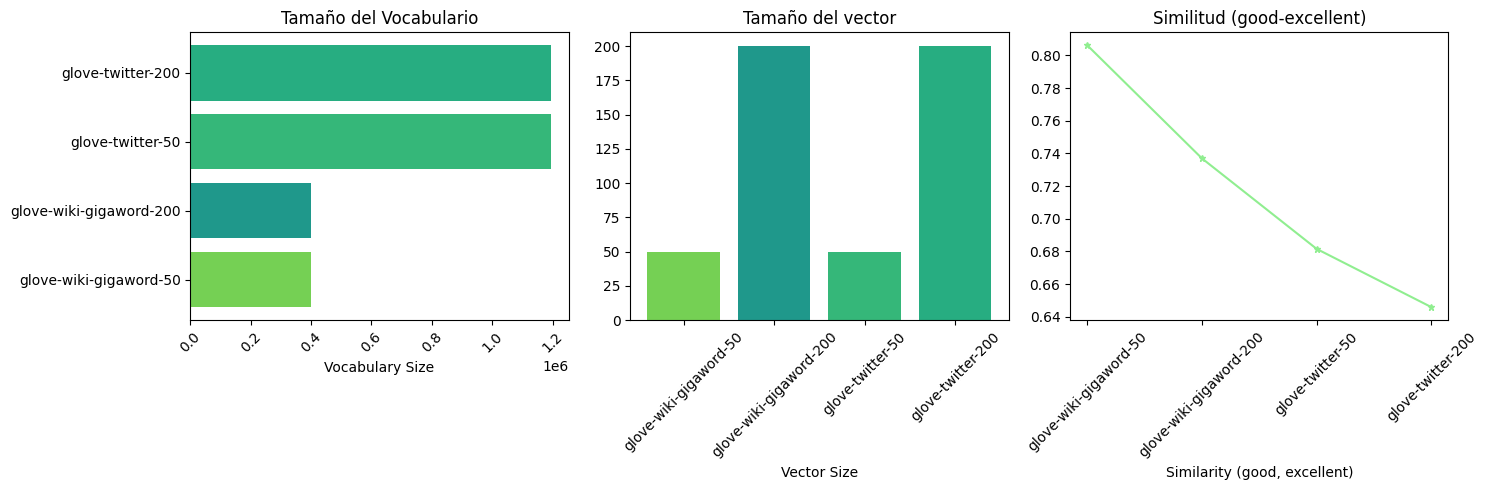

In [ ]:
bar_colors = [plt.cm.viridis(random.random()) for _ in range(len(results_df['Model Name'].tolist()))]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.barh(results_df['Model Name'].tolist(), results_df['Vocabulary Size'].tolist(), color=bar_colors)
plt.xlabel('Vocabulary Size')
plt.title('Tamaño del Vocabulario')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar(results_df['Model Name'].tolist(), results_df['Vector Size'].tolist(), color=bar_colors)
plt.xlabel('Vector Size')
plt.title('Tamaño del vector')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.plot(results_df['Model Name'].tolist(), results_df['Similarity (good, excellent)'].tolist(), color='lightgreen', marker='*', linestyle='-', markersize=5)
plt.xlabel('Similarity (good, excellent)')
plt.title('Similitud (good-excellent)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Palabras similares a "good" por modelo:

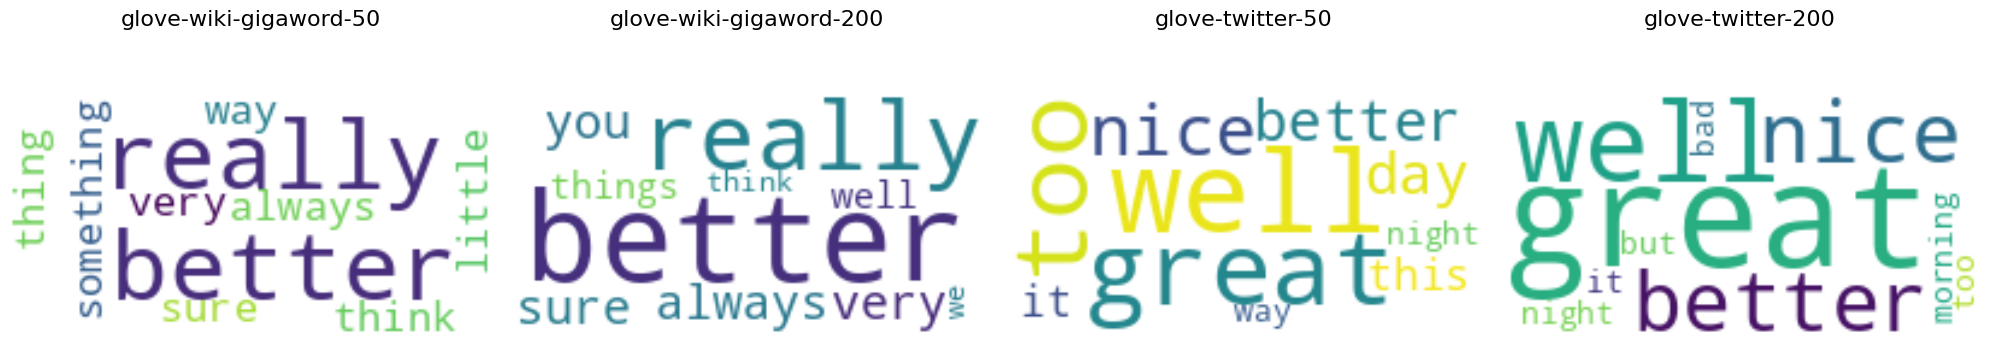

In [ ]:
fig, axes = plt.subplots(1, len(results_df['Model Name']), figsize=(20, 10))
axes = axes.flatten()

for i, similar_words in enumerate(results_df['Similar Words (good)']):

    model_name = results_df['Model Name'][i]

    # Crear un diccionario donde la clave es la palabra y el valor es la similaridad
    word_freq = {word: similarity for word, similarity in similar_words}

    # Crear la nube de palabras utilizando las similaridades como pesos
    wordcloud = WordCloud(width=200, height=100, background_color='white', colormap='viridis').generate_from_frequencies(word_freq)

    # Mostrar la nube de palabras en la subgráfica
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(model_name, fontsize=16, pad=50)

plt.tight_layout()
plt.show()

Modelos fasttext en inglés y español (https://fasttext.cc/docs/en/crawl-vectors.html):

In [ ]:
#####
# Obtener los modelos publicados
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz

# fasttext.util.download_model('en', if_exists='ignore')  # Inglés
# ft_en = fasttext.load_model('cc.en.300.bin')

# fasttext.util.download_model('es', if_exists='ignore')  # Español
# ft_es = fasttext.load_model('cc.es.300.bin')

# Reducir la dimensión de 300 a 50
# fasttext.util.reduce_model(ft_en, 50)
# fasttext.util.reduce_model(ft_es, 50)

# print(ft_en.get_dimension())
# print(ft_es.get_dimension())

# Guardar los modelos descargados para uso posterior
# ft_en.save_model('cc.en.50.bin')
# ft_es.save_model('cc.es.50.bin')

#####

In [ ]:
# Obtener de gdrive los modelos ya previamente descargados
file_id_en = '1XFobRGsyG1PJnLNuAlLZ1lWwDZIIzih3'
file_id_es = '1YXPZrW_GRHH-EcivEb256VFXfeevGhgi'

url_en = f'https://drive.google.com/uc?export=download&id={file_id_en}'
url_es = f'https://drive.google.com/uc?export=download&id={file_id_es}'



In [ ]:
gdown.download(url_en, 'cc.en.300.bin', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1XFobRGsyG1PJnLNuAlLZ1lWwDZIIzih3
From (redirected): https://drive.google.com/uc?export=download&id=1XFobRGsyG1PJnLNuAlLZ1lWwDZIIzih3&confirm=t&uuid=d1dc86f5-d8c7-454b-a3c9-6f379c392760
To: /content/cc.en.300.bin
100%|██████████| 7.24G/7.24G [01:52<00:00, 64.5MB/s]


'cc.en.300.bin'

In [ ]:
gdown.download(url_es, 'cc.es.300.bin', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1YXPZrW_GRHH-EcivEb256VFXfeevGhgi
From (redirected): https://drive.google.com/uc?export=download&id=1YXPZrW_GRHH-EcivEb256VFXfeevGhgi&confirm=t&uuid=30800661-dd97-4046-82ce-afe6e5d53ee2
To: /content/cc.es.300.bin
100%|██████████| 7.24G/7.24G [02:14<00:00, 53.9MB/s]


'cc.es.300.bin'

Obtener vectores de palabras y similaridades:

In [ ]:
# Palabra ejemplo para ambos idiomas
sample_word = 'animal'

In [ ]:
# Inglés
# Cargar modelo
ft_en = fasttext.load_model('cc.en.300.bin')

# Obtener el vector para la palabra
word_vector_en = ft_en.get_word_vector(sample_word)
print(f'(EN): {word_vector_en}')

# Similaridades
similar_words_en = ft_en.get_nearest_neighbors(sample_word)


(EN): [ 0.04479693  0.027031    0.03346993  0.15171535  0.0452813  -0.06327058
  0.06900101  0.00573356 -0.05926253 -0.05290614  0.02238144 -0.08235703
  0.05228892  0.00308938 -0.01548715 -0.02044515  0.07284472 -0.13103947
 -0.05626991  0.02259643  0.03404495 -0.00183976  0.00202845  0.06105919
 -0.04252208 -0.05984194  0.06269011  0.01361966  0.08967797  0.09470527
 -0.00708289  0.00740483  0.03766372  0.04475402 -0.04988436  0.00123457
  0.01674096  0.04347558  0.04096343 -0.175077    0.03875751  0.04642917
 -0.05348787 -0.0204423  -0.12953064 -0.03859648  0.08705501  0.0019533
 -0.08044798  0.06363063 -0.06067479 -0.01389921 -0.08566976 -0.02822834
 -0.04832473  0.07523517  0.09231753 -0.0423235  -0.04982525 -0.04110409
 -0.04819975  0.06581146  0.11001855  0.02206202 -0.07212039  0.00348789
  0.09508302  0.09130121 -0.06647383 -0.1050139   0.00922835 -0.00325021
 -0.01067389 -0.06706741  0.00165129 -0.06936747  0.02243533  0.00502033
 -0.05240512  0.07723349  0.02798783 -0.063637

In [ ]:
# Liberar memoria
del(ft_en)

In [ ]:
# Español
# Cargar modelo
ft_es = fasttext.load_model('cc.es.300.bin')

# Obtener el vector para la palabra
word_vector_es = ft_es.get_word_vector(sample_word)
print(f'(ES): {word_vector_es}')

# Similaridades
similar_words_es = ft_es.get_nearest_neighbors(sample_word)


(ES): [ 0.02806436  0.02334383  0.04673745 -0.00454225  0.13279936 -0.03834279
 -0.01005248  0.06498203 -0.11470615 -0.05445597  0.14708059  0.02324642
 -0.0497353  -0.07630675 -0.09280541  0.04041931  0.07788938 -0.07112886
 -0.00072821 -0.01207412 -0.04589009 -0.03262752  0.06767314 -0.01617336
  0.01928666  0.00410455 -0.04102451 -0.07468314 -0.01817796 -0.05727516
 -0.02655041 -0.03520666 -0.02056398  0.00607399 -0.02756745 -0.06052889
 -0.00211728  0.06548043  0.00617221 -0.05072435  0.00323496 -0.01748382
 -0.04773492  0.05151312  0.01842308  0.02166589  0.03199322 -0.04488647
  0.04913216 -0.03358204  0.00473358 -0.03516429  0.07646992 -0.02183132
  0.0371008   0.08570733  0.10840932  0.01062343 -0.04762086 -0.01057404
 -0.11239784 -0.06280692 -0.00801744 -0.09425558 -0.00762403 -0.04936521
 -0.06659788  0.04077137 -0.07461877 -0.09902438 -0.02122217  0.03107829
 -0.00540837 -0.03810567  0.10182668 -0.04748188  0.02053979  0.0141231
  0.06496209 -0.03541571  0.01857821  0.036336

In [ ]:
# Liberar memoria
del(ft_es)

In [ ]:
print(f"Palabras similares a '{sample_word}':\n")
results = []

for (similarity_en, word_en), (similarity_es, word_es) in zip(similar_words_en, similar_words_es):

    results.append([word_en, f'{similarity_en:.4f}', word_es, f'{similarity_es:.4f}'])

columns = ['Inglés', '# Sim_en', 'Español', '# Sim_es']
results_df = pd.DataFrame(results, columns=columns)
display(results_df.style.hide(axis='index'))


Palabras similares a 'animal':



**Conclusiones**

El tamaño del vocabulario, así como el conjunto de datos y la técnica empleada, son factores cruciales que influyen en la calidad y efectividad de los embeddings de palabras.   
 - Un vocabulario limitado puede llevar a embeddings que no generalizan bien en contextos variados.   
 Por otro lado, un vocabulario excesivamente amplio puede incluir ruido y disminuir la calidad de los embeddings.
 - Un vocabulario más grande puede captar una mayor diversidad de palabras, pero eso no significa que se logre captar adecuadamente las relaciones entre ellas.
 - Un conjunto de datos más grande y diverso generalmente proporciona un contexto más rico, lo que puede ayudar a capturar las relaciones semánticas entre palabras de manera más efectiva.
 - Un modelo entrenado en un vocabulario y dataset adecuados logrará mostrar relaciones semánticas más claras.  
 - La elección entre FastText y GloVe dependerá del contexto y de las necesidades específicas del proyecto.

| Modelo  | Ventajas | Desventajas      |
|---------|------|-------------|
| FastText    | • Considera subpalabras, lo que le permite generar vectores para palabras no vistas <br>y manejar mejor las palabras compuestas. Esto es especialmente útil <br>para idiomas con morfología rica o para vocabularios que contienen errores tipográficos.<br><br>• Mejor manejo de palabras raras y compuestas que no aparecen en el conjunto de entrenamiento.<br><br>• Ofrece modelos preentrenados en múltiples idiomas, lo que es ventajoso para proyectos multilingües.  | • Modelos más grandes debido a la representación de subpalabras.<br><br>• Puede requerir más tiempo de entrenamiento en comparación con GloVe.|
| Glove     | • Es relativamente más simple y puede ser más rápido de entrenar en comparación con FastText, <br>especialmente en conjuntos de datos grandes.<br><br>• En muchos casos, proporciona buenos resultados en tareas de similaridad y agrupamiento, <br>ya que se basa en la matriz de coocurrencia de palabras.   | • No puede manejar palabras no vistas; si una palabra no está en el vocabulario, <br>no puede generar un vector para ella.<br><br>• Menos flexibilidad, no utiliza subpalabras, <br>lo que puede limitar su rendimiento en ciertas aplicaciones.   |



### Test de analogía

En el contexto de procesamiento de lenguaje natural y embeddings de palabras, los tests de analogía son comúnmente usados para evaluar la calidad de los embeddings generados.

Un test de analogía generalmente presenta una relación entre un par de palabras (A y B) y busca completar la relación usando otro par de palabras (C y D).  
La estructura típica es:  A : B :: C : ?

"A se relaciona con B de la misma manera que C se relaciona con D".   
La tarea es encontrar la palabra que mejor complete la relación.
<br>
<br>
Ejemplo:  
rey : reina :: hombre : ?

La respuesta correcta sería "mujer", porque la relación entre "rey" y "reina" es análoga a la relación entre "hombre" y "mujer".
<br>
<br>

Cuando se evalúan embeddings de palabras, se pueden realizar pruebas de analogía para verificar cómo el modelo captura relaciones semánticas.  
<br>

Por ejemplo, dado un conjunto de embeddings de palabras, se puede usar la  fórmula:

vector(D) ≈ vector(B) - vector(A) + vector(C)  
<br>

Esto implica que si el modelo está funcionando correctamente, la suma de los vectores debería dar un vector que se asemeje al de D (en este caso, "mujer").  
<br>
<br>
Los tests de analogía son importantes porque:

* Evalúan la calidad de los embeddings - Ayudan a determinar si el modelo ha aprendido relaciones semánticas adecuadas.
* Ofrecen una forma intuitiva de entender el espacio vectorial - Permiten entender mejor cómo las palabras se relacionan entre sí en el espacio de embeddings.


*Carga de modelos previamente descargados:*

In [ ]:
# Descargar modelo compartido de gDrive al entorno de gColab
def getSharedModel(file_id, file_name):

  # Obtener desde gDrive
  url = f'https://drive.google.com/uc?export=download&id={file_id}'

  # Ruta al archivo en Google Colab
  file_path = '/content/' + file_name

  # Verificar si el archivo ya existe en el entorno de ejecución
  if not os.path.exists(file_path):
      # El archivo no se encuentra en el entorno
      gdown.download(url, file_name, quiet=False)
  else:
      # El archivo ya existe en el entorno. No es necesario descargarlo.
      pass

In [ ]:
# GloVe
# Desde el sitio de la Universidad de Standford:
# https://nlp.stanford.edu/projects/glove/

file_name = 'glove.6B.50d.txt'
getSharedModel('1IscT3paVQ46fMtqh-FJg3k9Fi0IytXcf', file_name)

glove_file_path = '/content/' + file_name


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1IscT3paVQ46fMtqh-FJg3k9Fi0IytXcf
From (redirected): https://drive.google.com/uc?export=download&id=1IscT3paVQ46fMtqh-FJg3k9Fi0IytXcf&confirm=t&uuid=a223166c-9f42-4199-815f-5226feea41bf
To: /content/glove.6B.50d.txt
100%|██████████| 171M/171M [00:01<00:00, 95.0MB/s]


In [ ]:
# Función  para cargar embeddings de Glove previamente descargados

def load_glove_embeddings(file_path):

    print("Cargando embeddings de GloVe...")

    word_vectors = {}

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            word_vectors[word] = vector

    print(f"Embeddings de GloVe cargados ({len(word_vectors)})")
    return word_vectors


In [ ]:
# Ejemplo:
word_vectors = load_glove_embeddings(glove_file_path)

Cargando embeddings de GloVe...
Embeddings de GloVe cargados (400000)


In [ ]:
# Función para resolver analogías

def analogical_reasoning(word1, word2, word3, word_vectors, top_n=5):

    if word1 not in word_vectors or word2 not in word_vectors or word3 not in word_vectors:
        print("Una o más palabras no están en el vocabulario de GloVe.")
        return []

    # Calcula el vector de la analogía (B - A + C)
    vector_analogy = word_vectors[word2] - word_vectors[word1] + word_vectors[word3]

    # Calcula las distancias coseno con todas las palabras en el vocabulario
    similarities = {}
    for word, vector in word_vectors.items():
        if word != word1 and word != word2 and word != word3:
            similarity = 1 - cosine(vector, vector_analogy)  # Similaridad coseno (valor entre -1 y 1)
            similarities[word] = similarity

    # Ordenar por la similitud coseno
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Devolver las N palabras más similares
    return sorted_similarities[:top_n]


In [ ]:
# Ejemplo - Test de analogía:

word1 = 'king'
word2 = 'queen'
word3 = 'man'

# Realizar la analogía: "king" es a "queen" como "man" es a ?
result = analogical_reasoning(word1, word2, word3, word_vectors)

print(f"Analogía '{word1} : {word2} :: {word3} : ?' resultó en:\n")

for word, similarity in result:
    print(f"  {word} ({similarity:.4f})")


Analogía 'king : queen :: man : ?' resultó en:

  woman (0.8904)
  girl (0.8454)
  her (0.7846)
  boy (0.7763)
  she (0.7620)


In [ ]:
# Download archivos pickle desde google drive:
#!curl -L -o 'fasttext.pkl' 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'
#!curl -L -o 'gloveembedding.pkl' 'https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t'

# Link de descarga de los embeddings de GloVe
# http://nlp.stanford.edu/data/glove.twitter.27B.zip
# Link de descarga de los embeddings 300 de fastText
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

# Paper de GloVe
# https://nlp.stanford.edu/pubs/glove.pdf

# Papers de FastText
# https://arxiv.org/pdf/1607.04606.pdf
# https://arxiv.org/abs/1607.01759
# https://arxiv.org/abs/1612.03651


In [ ]:
getSharedModel(file_id='1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa', file_name='fasttext.pkl')

getSharedModel(file_id='1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94', file_name='gloveembedding.pkl')

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa
From (redirected): https://drive.google.com/uc?export=download&id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&confirm=t&uuid=2157a264-7750-4fd6-b62b-e165079a2237
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:36<00:00, 78.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94
From (redirected): https://drive.google.com/uc?export=download&id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&confirm=t&uuid=04bff745-e41d-4294-a91f-f925c52f8144
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:04<00:00, 117MB/s]


In [ ]:
# Clase para cargar los embeddings a partir de sus pickles
# Funciones para obtener términos dados índices y viceversa

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self, word_to_vec_model_txt_path, pkl_path, n_features, word_max_size):
        """
        Inicializa la clase WordsEmbeddings, cargando un modelo de embeddings de palabras.

        :param word_to_vec_model_txt_path: Ruta al archivo de texto del modelo de embeddings (GloVe, FastText, etc.).
        :param pkl_path: Ruta al archivo pickle donde se guardarán los embeddings procesados.
        :param n_features: Número de dimensiones del vector de cada palabra (por defecto 50).
        :param word_max_size: Tamaño máximo de las palabras a considerar (por defecto 60).
        """

        self.WORD_TO_VEC_MODEL_TXT_PATH = word_to_vec_model_txt_path
        self.PKL_PATH = pkl_path
        self.N_FEATURES = n_features
        self.WORD_MAX_SIZE = word_max_size

        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)

        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()

        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])

        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings



In [ ]:
# Clases particulares para manejar los embeddings de Glove y Fasttext
# que heredan de la clase anterior WordsEmbeddings

class GloveEmbeddings(WordsEmbeddings):

    def __init__(self,
                 word_to_vec_model_txt_path='glove.twitter.27B.50d.txt',
                 pkl_path='gloveembedding.pkl',
                 n_features=50,
                 word_max_size=60):

        super().__init__(word_to_vec_model_txt_path, pkl_path, n_features, word_max_size)


class FasttextEmbeddings(WordsEmbeddings):

    def __init__(self,
                 word_to_vec_model_txt_path='cc.en.300.vec',
                 pkl_path='fasttext.pkl',
                 n_features=300,
                 word_max_size=60):

        super().__init__(word_to_vec_model_txt_path, pkl_path, n_features, word_max_size)


In [ ]:
# Graficar la matriz de similaridad
def plot_matrix_distance(words, dist):
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot()
    sns.heatmap(dist, xticklabels=words, yticklabels=words,
                annot=True, fmt=".2f", cmap="YlGnBu", ax=ax, mask=np.triu(dist))
    plt.show()

# Si se usa scipy la distancia coseno no es la similitud coseno (esta "negada")
def embeddings_matrix_distance(model, words):
    print("Cantidad de palabras:", len(words))
    emb = model.get_words_embeddings(words)
    print("Dimensiones de los embeddings:", emb.shape)
    dist = pairwise.cosine_similarity(emb, emb)
    plot_matrix_distance(words, dist)


In [ ]:
# Instanciar embedding de fasttext
model_fasttext = FasttextEmbeddings()
words_fasttext=[model_fasttext.embeddings[i][0] for i in range(model_fasttext.embeddings.shape[0])]

In [ ]:
# cantidad de palabras en fasttext
model_fasttext.embeddings.shape[0]

2000001

In [ ]:
# Palabras a ensayar
# Algunas relativas con saludos y otras con dispositivos
words = ["hi", "hello", "bye", "goodbye", "morning", "computer", "machine", "laptop", "device", "printer"]

Cantidad de palabras: 10
Dimensiones de los embeddings: (10, 300)


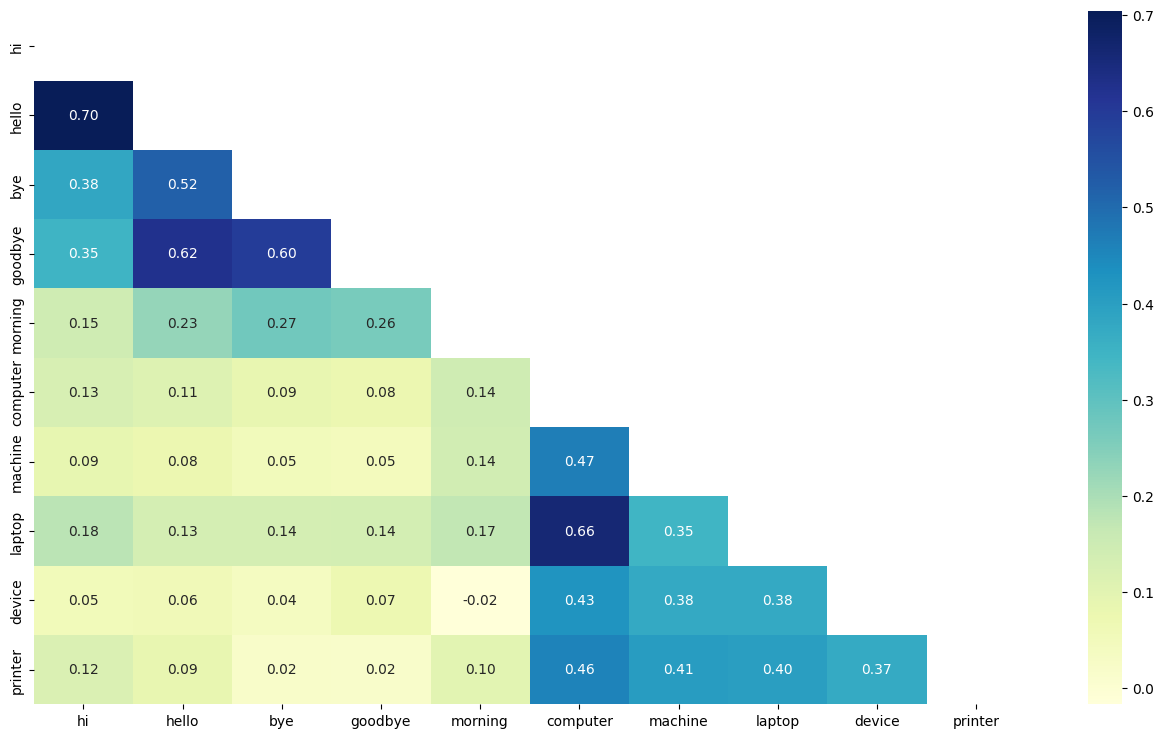

In [ ]:
embeddings_matrix_distance(model_fasttext, words)

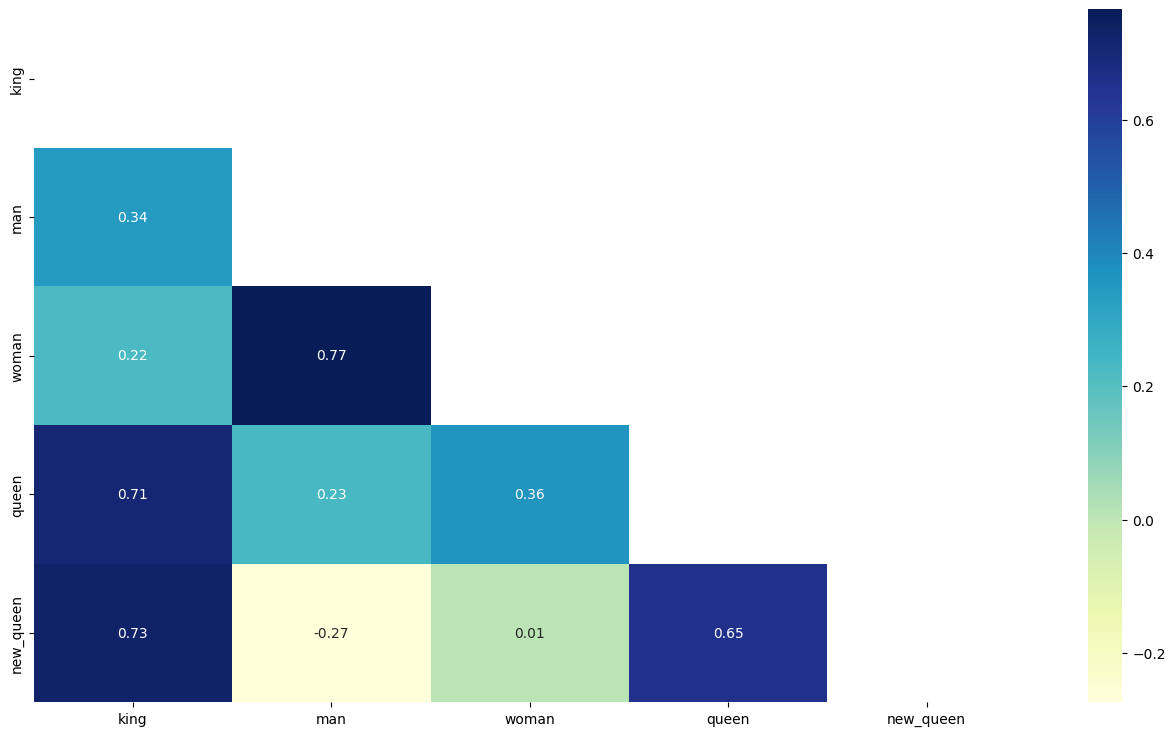

In [ ]:
# Test de analogía
test_words = ['king', 'man', 'woman', 'queen']
test_emb = model_fasttext.get_words_embeddings(test_words)

# king - man + woman
new_queen = test_emb[0] - test_emb[1] + test_emb[2]

new_words = test_words + ['new_queen']
new_emb = np.append(test_emb, new_queen.reshape(1, -1), axis=0)

dist = pairwise.cosine_similarity(new_emb, new_emb)

plot_matrix_distance(new_words, dist)

In [ ]:
# Más allá de las palabras propuestas, ver cuál sería la palabra
# cuyo embedding es más similar al de 'new_queen'
embeddings_fasttext = []

for idx,emb in enumerate(model_fasttext.embeddings):
  embeddings_fasttext.append(emb[1])

embeddings_fasttext = np.array(embeddings_fasttext)

In [ ]:
# Calcular la similaridad de 'new_queen' contra todos los vectores
similarities = np.squeeze(pairwise.cosine_similarity(embeddings_fasttext,np.array([new_queen])))

In [ ]:
# 10 vectores más similares
args_sorted = np.argsort(similarities)[::-1][:10]

for arg in args_sorted:
  print(f'{words_fasttext[arg]}: {similarities[arg]}')

king: 0.7286648154258728
queen: 0.6542776823043823
kings: 0.5410012006759644
queen-mother: 0.5250992178916931
Queen: 0.5074200630187988
royal: 0.5004721879959106
king-: 0.49447429180145264
queens: 0.49149155616760254
monarch: 0.49141061305999756
queenship: 0.48376166820526123


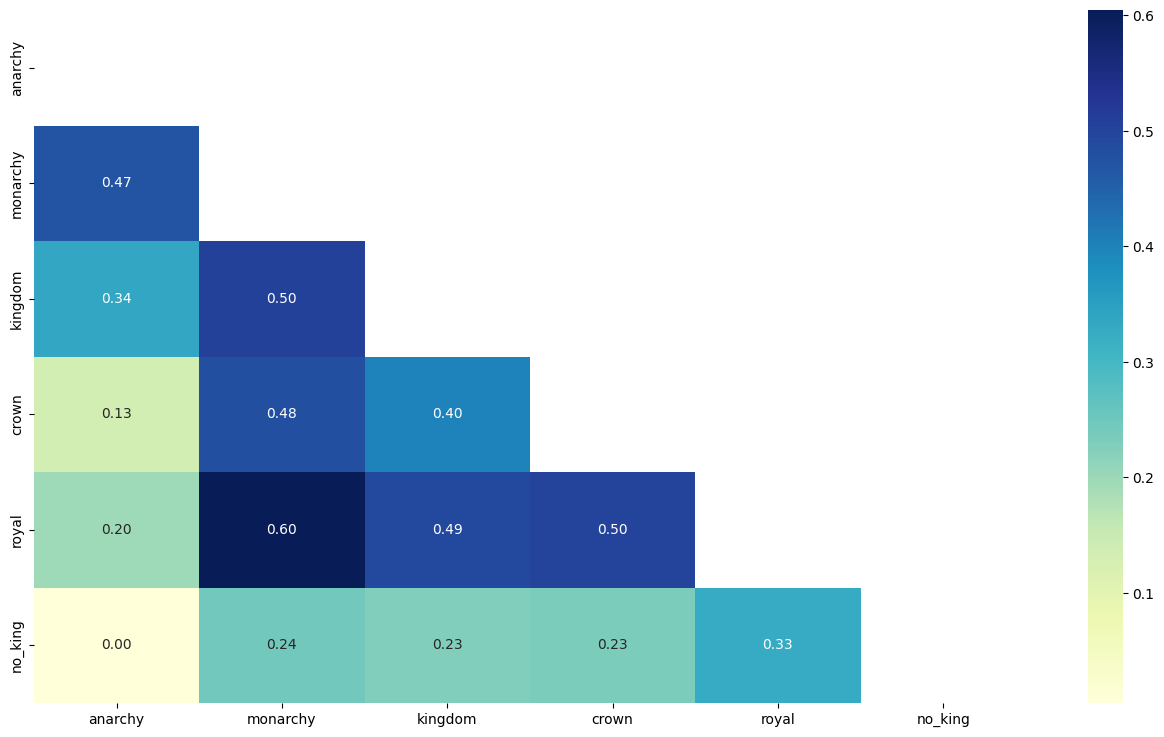

In [ ]:
test_words2 = ['anarchy', 'monarchy', 'kingdom', 'crown', 'royal']
test_emb2 = model_fasttext.get_words_embeddings(test_words2)

# king - man
no_king = test_emb[0] - test_emb[1]

new_words2 = test_words2 + ['no_king']
new_emb2 = np.append(test_emb2, no_king.reshape(1, -1), axis=0)

dist2 = pairwise.cosine_similarity(new_emb2, new_emb2)

plot_matrix_distance(new_words2, dist2)

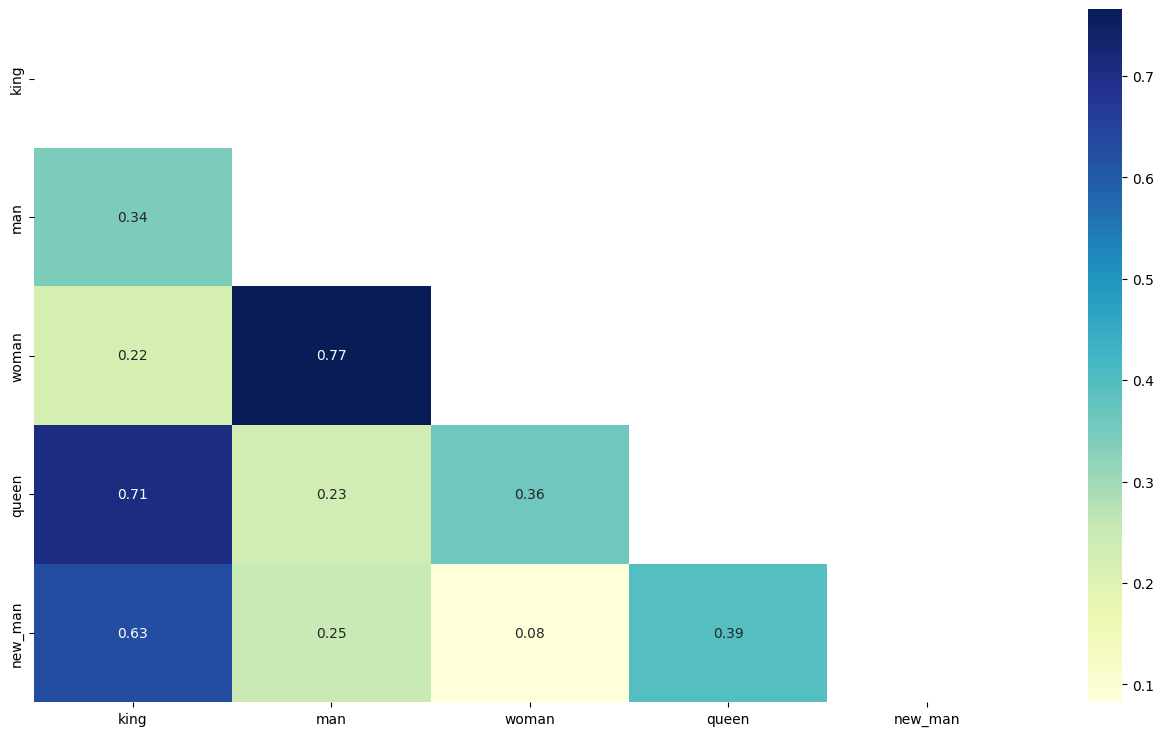

In [ ]:
# king - royal
new_man = test_emb[0] - test_emb2[4]

new_words3 = test_words + ['new_man']
new_emb3 = np.append(test_emb, new_man.reshape(1, -1), axis=0)

dist3 = pairwise.cosine_similarity(new_emb3, new_emb3)

plot_matrix_distance(new_words3, dist3)

In [ ]:
# Liberar memoria eliminando el modelo
del(model_fasttext)

In [ ]:
# Embeddings de GloVe
model_glove = GloveEmbeddings()
words_glove=[model_glove.embeddings[i][0] for i in range(model_glove.embeddings.shape[0])]

In [ ]:
# cantidad de palabras en GloVe
print(model_glove.embeddings.shape[0])

1193514


Cantidad de palabras: 10
Dimensiones de los embeddings: (10, 50)


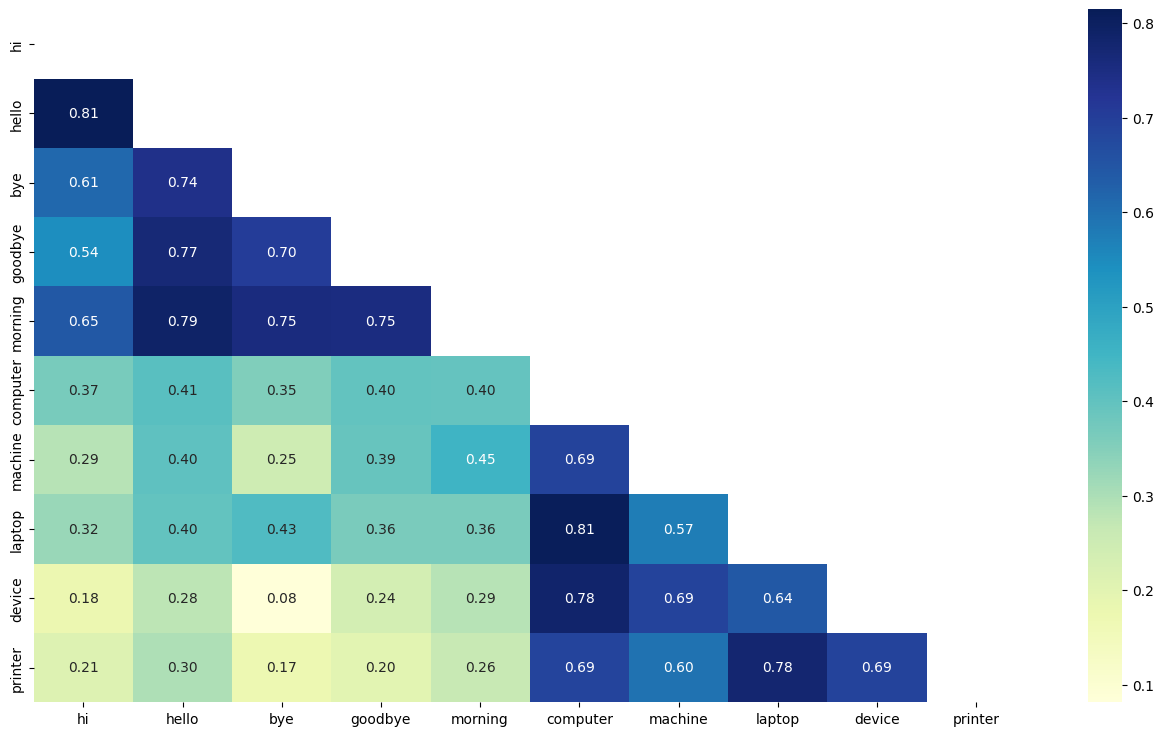

In [ ]:
embeddings_matrix_distance(model_glove, words)

Diferentes embeddings capturan diferentes relaciones semánticas y en distinto grado:
- En los embeddings de Glove morning está muy relacionado con los saludos y este comportamiento podría no ser deseado.
- En los embeddings de Fasttext la similitud entre los dos grupos de palabras elegidas no es tan alta.

In [ ]:
# Liberar memoria eliminando el modelo
del(model_glove)

### Entrenamiento y aprendizaje

*CBOW (Continuous Bag of Words) y Skip-gram *son dos arquitecturas populares utilizadas en modelos de aprendizaje de palabras, específicamente en Word2Vec, que es una técnica para generar embeddings de palabras.
<br><br>

**CBOW (Continuous Bag of Words)**  
* Descripción: CBOW predice una palabra objetivo (target word) a partir de su contexto, es decir, de las palabras que la rodean. Utiliza las palabras en el contexto para predecir la palabra central.

* Funcionamiento: Se toma un conjunto de palabras de contexto (por ejemplo, las dos palabras antes y las dos palabras después de la palabra objetivo).
Se representan estas palabras de contexto como vectores y se promedian (o se suman).
Se utiliza esta representación promedio para predecir la palabra objetivo mediante una capa de salida.  
Ejemplo: En la frase "El gato está en el jardín", si consideramos "está" como la palabra objetivo, las palabras de contexto serían "El", "gato", "en", "el", "jardín".  
<br>

**Skip-gram**  
* Descripción: Skip-gram, en contraste con CBOW, toma una palabra objetivo y predice las palabras de contexto que aparecen alrededor de ella. Es especialmente útil para aprender representaciones de palabras raras.  
* Funcionamiento: Se selecciona una palabra objetivo.  Se utiliza esa palabra para predecir las palabras que se encuentran en el contexto.
La red se entrena para maximizar la probabilidad de que las palabras de contexto aparezcan dado la palabra objetivo.  
Ejemplo: En la misma frase "El gato está en el jardín", si tomamos "está" como la palabra objetivo, el modelo intentaría predecir "El", "gato", "en", "el", "jardín".
<br><br>


| ... | CBOW | Skip-gram |
|-----|-----|-----|
| Dirección | CBOW predice la palabra objetivo a partir del contexto. | Skip-gram hace lo contrario, prediciendo el contexto a partir de la palabra objetivo. |
| Uso | CBOW tiende a ser más rápido y eficiente cuando el corpus es grande y las palabras de contexto son frecuentes. | Skip-gram es mejor para aprender palabras raras y es más robusto en corpus pequeños. |  

<br><br>
Ambas arquitecturas tienen sus ventajas y desventajas y son utilizadas en diferentes situaciones dependiendo de la naturaleza del corpus y los objetivos del modelo de lenguaje.

### Negative sampling

***Negative sampling*** es una técnica utilizada en el entrenamiento de modelos de aprendizaje de palabras, como Word2Vec, para optimizar el proceso de aprendizaje y hacer que el modelo sea más eficiente.   
En lugar de actualizar los pesos de la red para todas las palabras del vocabulario en cada iteración, el negative sampling permite enfocarse en solo unas pocas palabras, lo que reduce el costo computacional.  
<br>
*Objetivo del modelo:*  
En el caso de modelos como Skip-gram, el objetivo es maximizar la probabilidad de que las palabras de contexto aparezcan dada una palabra objetivo. Sin embargo, calcular esta probabilidad para todas las palabras del vocabulario puede ser muy costoso, especialmente en vocabularios grandes.  
<br>
*Muestra negativa:*
En lugar de considerar todas las palabras del vocabulario, negative sampling introduce el concepto de "muestras negativas".   
Esto implica elegir algunas palabras que no están en el contexto de la palabra objetivo (es decir, que no deberían estar relacionadas).  Por cada palabra de contexto positiva (la palabra objetivo y sus contextos), se seleccionan varias palabras negativas aleatorias.  
<br>
*Entrenamiento:*  
Durante el entrenamiento:
* Se maximiza la probabilidad de las palabras de contexto positivas.
* Se minimiza la probabilidad de las palabras negativas. Esto se traduce en penalizar el modelo si una palabra negativa es considerada como un contexto de la palabra objetivo.  
<br><br>

*Ventajas de Negative Sampling:*  
* *Eficiencia*: Reduce significativamente el tiempo de entrenamiento al no requerir la actualización de todos los pesos de la red para cada palabra en el vocabulario.
* *Mejora la convergencia:* Puede ayudar al modelo a aprender más rápidamente y con mejores representaciones, ya que se centra en ejemplos positivos y negativos.
* *Flexibilidad*: Permite ajustar la cantidad de muestras negativas, lo que puede ser útil para adaptar el modelo a diferentes conjuntos de datos y tareas.  
<br>
<br>

*Ejemplo:*  

Supongamos que se entrena un modelo Skip-gram con la palabra "perro" y el contexto "ladrar". En lugar de calcular la probabilidad de "perro" con todas las palabras del vocabulario, se podría:  
* Tomar "ladrar" como un ejemplo positivo.
* Elegir, por ejemplo, 5 palabras negativas aleatorias como "mesa", "coche", "luz", "sol", y "agua".  

El modelo se entrenaría para maximizar la probabilidad de "ladrar" dado "perro" y minimizar la probabilidad de las palabras negativas.  

###  t-SNE

Visualizar embeddings de palabras utilizando t-SNE (t-Distributed Stochastic Neighbor Embedding) es una manera de explorar las relaciones semánticas entre las palabras en un espacio de alta dimensión.   


In [ ]:
# Ejemplo modelo preentrenado de GloVe
glove_model = api.load("glove-wiki-gigaword-100")  # GloVe con 100 dimensiones


[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
# Seleccionar algunas palabras para visualizar
words = ["king", "queen", "man", "woman", "child", "apple", "banana", "dog", "cat", "computer",
         "soccer", "painting", "music", "happy", "sad", "red", "blue", "city", "forest"]
word_vectors = np.array([glove_model[word] for word in words])

In [ ]:
# Aplicar t-SNE para reducción a 2D
tsne_2d = TSNE(n_components=2, perplexity=15, random_state=42)
embeddings_2d = tsne_2d.fit_transform(word_vectors)

# Aplicar t-SNE para reducción a 3D
tsne_3d = TSNE(n_components=3, perplexity=15, random_state=42)
embeddings_3d = tsne_3d.fit_transform(word_vectors)


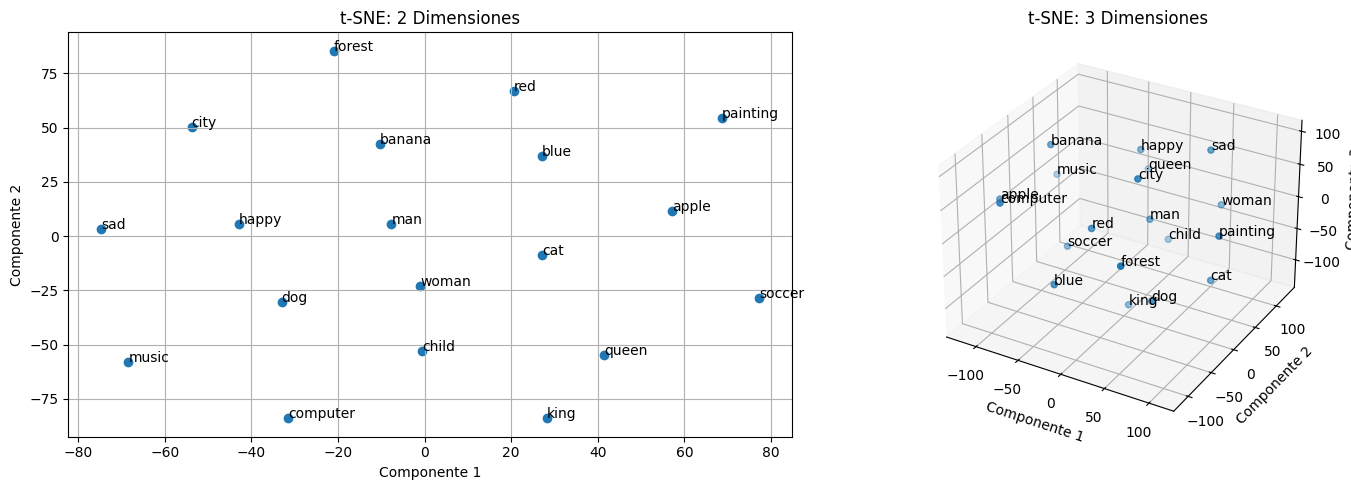

In [ ]:
# Crear una figura con dos subgráficos (uno para 2D y otro para 3D)
fig = plt.figure(figsize=(15, 5))

# Subgráfico 1: Visualización 2D
ax1 = fig.add_subplot(121)
ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

for i, word in enumerate(words):
    ax1.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))

ax1.set_title("t-SNE: 2 Dimensiones")
ax1.set_xlabel("Componente 1")
ax1.set_ylabel("Componente 2")
ax1.grid()

# Subgráfico 2: Visualización 3D
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2])

for i, word in enumerate(words):
    ax2.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], word)

ax2.set_title("t-SNE: 3 Dimensiones")
ax2.set_xlabel("Componente 1")
ax2.set_ylabel("Componente 2")
ax2.set_zlabel("Componente 3")
ax2.grid()

plt.tight_layout()
plt.show()

## **Desafío - Custom Word Embeddings**

### Objetivo

Utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto.

### Datos

Utilizo como dataset, los cuentos más famosos de los hermanos Grimm.  

Se trata de un corpus que armé a partir de cuentos infantiles en idioma español obtenidos del sitio: https://www.grimmstories.com/  

Son 50 cuentos en formato txt.


In [ ]:
# Descargar carpeta de archivos
zip_id='141rtuhfc5c1lAHcuvQjax8g322M1FrB3'
url = f'https://drive.google.com/uc?export=download&id={zip_id}'

gdown.download(url, 'grimmstories_es.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=141rtuhfc5c1lAHcuvQjax8g322M1FrB3
To: /content/grimmstories_es.zip
100%|██████████| 224k/224k [00:00<00:00, 34.7MB/s]


'grimmstories_es.zip'

In [ ]:
# Descomprimir el archivo sobreescribiendo si ya existe
!unzip -oq 'grimmstories_es.zip'

In [ ]:
# Listado de cuentos
grimmstories = os.listdir("/content/grimmstories_es/")

for i, story in enumerate(grimmstories):
  print (f'{i+1} - {story}')

1 - Las tres hojas de la serpiente.txt
2 - Los tres enanitos del bosque.txt
3 - La Bella Durmiente.txt
4 - Un Ojito, Dos Ojitos y Tres Ojitos.txt
5 - Blancanieves.txt
6 - Blancanieve y Rojaflor.txt
7 - El pescador y su mujer.txt
8 - Los doce hermanos.txt
9 - Las tres plumas.txt
10 - El Enano Saltarín (Rumpelstiltskin).txt
11 - Los tres pelos de oro del diablo.txt
12 - El fiel Juan.txt
13 - Rapunzel.txt
14 - El borriquillo.txt
15 - El rey Pico de Tordo.txt
16 - El diablo y su abuela.txt
17 - La Cenicienta.txt
18 - Las tres hilanderas.txt
19 - Historia de uno que hizo un viaje para saber lo que era miedo.txt
20 - La serpiente blanca.txt
21 - El doctor Sabelotodo.txt
22 - Los músicos de Brema.txt
23 - El pájaro de oro.txt
24 - Los siete cuervos.txt
25 - El gato y el ratón hacen vida en común.txt
26 - El lobo y la siete cabritillas.txt
27 - El lobo y la zorra.txt
28 - Juan de Hierro.txt
29 - El agua de la vida.txt
30 - Madre Nieve (Frau Holle).txt
31 - El Rey Rana o Enrique el Férreo.txt
3

In [ ]:
stories = []

for story in grimmstories:

  with open('/content/grimmstories_es/' + story, 'r', encoding='utf-8') as file:
    # Guardar el contenido completo del archivo reemplazando saltos de línea por espacio.
    content = file.read().replace('\n', ' ')

    stories.append({'file_name': story, 'content': content})

# Crear un DataFrame con los cuentos
df = pd.DataFrame(stories)

df.head()

file_name  \
0      Las tres hojas de la serpiente.txt   
1        Los tres enanitos del bosque.txt   
2                  La Bella Durmiente.txt   
3  Un Ojito, Dos Ojitos y Tres Ojitos.txt   
4                        Blancanieves.txt   

                                             content  
0  Vivía una vez un hombre tan pobre, que pasaba ...  
1  Éranse un hombre que había perdido a su mujer,...  
2  Hace muchos años vivían un rey y una reina qui...  
3  Érase una mujer que tenía tres hijas. La mayor...  
4  Había una vez, en pleno invierno, una reina qu...

In [ ]:
# Dataframe de cuentos infantiles
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  50 non-null     object
 1   content    50 non-null     object
dtypes: object(2)
memory usage: 928.0+ bytes


### Tokenización

Realizo la tokenización a nivel de palabras, cada palabra se trata como una unidad, ya que, el desafío  planteado es el análisis de similaridad de términos, y pruebas de analogías, y esto implica comparar estructuras a nivel palabras y no estructuras más grandes, por ejemplo, oraciones o párrafos.


In [ ]:
# Lista donde se guardarán los tokens (palabras)
tokens_list = []

# Recorrer cada fila del DataFrame
for _, row in df.iterrows():

    # Tokenizar el cuento en palabras usando Keras
    tokens_list.append(text_to_word_sequence(row['content']))

# tokens_list contiene las palabras tokenizadas de cada cuento
df['tokens'] = tokens_list

df.head()

file_name  \
0      Las tres hojas de la serpiente.txt   
1        Los tres enanitos del bosque.txt   
2                  La Bella Durmiente.txt   
3  Un Ojito, Dos Ojitos y Tres Ojitos.txt   
4                        Blancanieves.txt   

                                             content  \
0  Vivía una vez un hombre tan pobre, que pasaba ...   
1  Éranse un hombre que había perdido a su mujer,...   
2  Hace muchos años vivían un rey y una reina qui...   
3  Érase una mujer que tenía tres hijas. La mayor...   
4  Había una vez, en pleno invierno, una reina qu...   

                                              tokens  
0  [vivía, una, vez, un, hombre, tan, pobre, que,...  
1  [éranse, un, hombre, que, había, perdido, a, s...  
2  [hace, muchos, años, vivían, un, rey, y, una, ...  
3  [érase, una, mujer, que, tenía, tres, hijas, l...  
4  [había, una, vez, en, pleno, invierno, una, re...

### Embeddings

Modifico la clase Callback propuesta de modo tal de poder graficar las curvas de la función de pérdida durante el entrenamiento.

In [ ]:
# Guardar registro de la pérdida para análisis posterior
class LossHistory(CallbackAny2Vec):

    def __init__(self):

        self.epoch = 0
        self.losses = []


    def on_epoch_end(self, model):

        # Pérdida acunulada
        loss = model.get_latest_training_loss()


        if self.epoch == 0:
            epoch_loss = loss

        else:
            epoch_loss = loss- self.loss_previous_step

        print('Loss after epoch {}: {}'.format(self.epoch + 1, epoch_loss))

        # Guardar la pérdida para la visualización posterior
        self.losses.append(epoch_loss)

        self.epoch += 1
        self.loss_previous_step = loss


    def plot_loss(self):

        plt.plot(range(self.epoch), self.losses)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Evolución de la Pérdida durante el Entrenamiento')
        plt.show()

In [ ]:
# Modelo generador de vectores
w2v_model = Word2Vec(
    min_count=5,            # frecuencia mínima de palabra para incluirla en el vocabulario
    window=2,               # cant de palabras antes y desp de la predicha
    vector_size=300,        # dimensionalidad de los vectores
    negative=20,            # cantidad de negative samples... 0 es no se usa
    workers=1,              # cantidad de hilos de procesamiento
    sg=1,                   # modelo 0:CBOW  1:skipgram
    hs=0                    # 0= negative sampling, 1= hierarchical softmax
  )


In [ ]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(tokens_list)

In [ ]:
# Tamaño del vocabulario
print("Cantidad de palabras distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de palabras distintas en el corpus: 1849


### Entrenamiento embeddings

In [ ]:
# Instancia del callback
loss_history = LossHistory()

In [ ]:
w2v_model.train(tokens_list,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[loss_history]
                 )

Loss after epoch 1: 748782.75
Loss after epoch 2: 553038.875
Loss after epoch 3: 510202.0
Loss after epoch 4: 477030.125
Loss after epoch 5: 437081.75
Loss after epoch 6: 437918.75
Loss after epoch 7: 434629.0
Loss after epoch 8: 432546.5
Loss after epoch 9: 415510.25
Loss after epoch 10: 403524.5
Loss after epoch 11: 401945.5
Loss after epoch 12: 398533.5
Loss after epoch 13: 398170.0
Loss after epoch 14: 395980.5
Loss after epoch 15: 394850.5
Loss after epoch 16: 393853.5
Loss after epoch 17: 391102.0
Loss after epoch 18: 390143.0
Loss after epoch 19: 385683.0
Loss after epoch 20: 376725.0


(966216, 1732960)

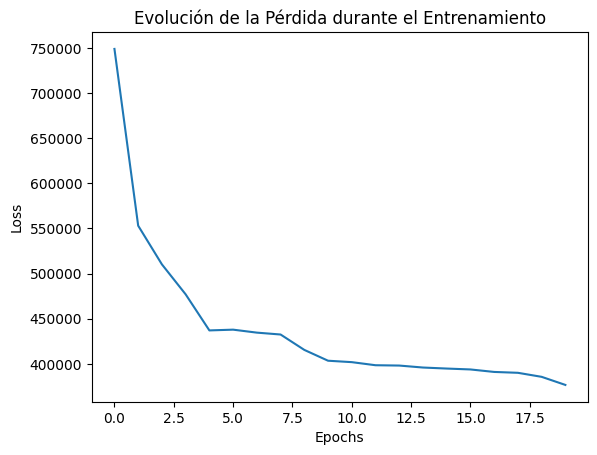

In [ ]:
# Al final del entrenamiento graficar la función de pérdida a lo largo de las épocas
loss_history.plot_loss()

### Ensayos

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["amor"], topn=10)

[('habrá', 0.8840914368629456),
 ('favor', 0.8814687132835388),
 ('silencio', 0.8647760152816772),
 ('precioso', 0.8595936298370361),
 ('gracia', 0.8587595224380493),
 ('fidelidad', 0.8575872182846069),
 ('compañera', 0.8554280996322632),
 ('vienen', 0.8541184067726135),
 ('desgracia', 0.8538438081741333),
 ('quedarte', 0.8522085547447205)]

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["alegría"], topn=10)

[('me', -0.16010800004005432),
 ('mi', -0.16467739641666412),
 ('te', -0.1685526818037033),
 ('erizo', -0.17071710526943207),
 ('día', -0.18159566819667816),
 ('sin', -0.18485110998153687),
 ('lo', -0.19053779542446136),
 ('volvió', -0.2037154585123062),
 ('soy', -0.20462901890277863),
 ('contestó', -0.2055995911359787)]

In [ ]:
# Ensayar con una palabra que no está en el vocabulario:
try:
  w2v_model.wv.most_similar(negative=["dieta"])
except KeyError as e:
  print(f"KeyError: {e}")

KeyError: "Key 'dieta' not present in vocabulary"


### Visualización

In [ ]:
def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [ ]:
# Graficar los embedddings en 2D

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

In [ ]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model, 3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

In [ ]:
# Guardar los vectores y labels como tsv para graficar en http://projector.tensorflow.org/
vectors = np.asarray(w2v_model.wv.vectors)
labels = list(w2v_model.wv.index_to_key)

np.savetxt("vectors.tsv", vectors, delimiter="\t")

with open("labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)

### Análisis exploratorio comparativo

A continuación realizo varios entrenamientos modificando parámetros del modelo para poder evaluar el desempeño comparativamente en cada escenario.

*Parámetros a modificar:*  
<br>

* **vector_size**   
Cambiar la dimensión de los vectores afecta la cantidad de información que cada palabra puede "capturar". Dimensiones más altas permiten más capacidad, pero pueden ser más lentas de entrenar y pueden llevar a un sobreajuste si no se tiene suficiente datos.  

* **window**  
El tamaño de la ventana de contexto puede influir mucho en la calidad del modelo. Una ventana pequeña captura más información de la estructura gramatical, mientras que una ventana mayor captura más contexto semántico.  


* **min_count**  
La frecuencia mínima para que una palabra sea considerada en el vocabulario. Valores más altos descartan palabras menos frecuentes, lo que puede ser útil para reducir el ruido, pero también puede perder palabras raras o relevantes.


* **sg (Skipgram vs. CBOW)**  
Skipgram es más efectivo para encontrar palabras raras o contextos más amplios. Con CBOW, el modelo se enfoca más en palabras frecuentes.


* **negative**   
El número de negativos utilizados en negative sampling afecta el equilibrio entre velocidad de entrenamiento y calidad de los vectores. Un número mayor puede mejorar la calidad, pero también puede aumentar el tiempo de entrenamiento.

 * *hs - Hierarchical Softmax* es un algoritmo de optimización utilizado en el entrenamiento de modelos de Word2Vec para calcular las probabilidades de las palabras en el vocabulario de manera más eficiente. A diferencia de Negative Sampling, que selecciona un pequeño número de palabras "negativas" para actualizar los pesos, Hierarchical Softmax utiliza una representación en forma de árbol binario (un árbol de Huffman) para hacer más eficiente el cálculo de la probabilidad de una palabra en el vocabulario.

In [ ]:
# sg
CBOW = 0
SKIPGRAM = 1


Realizo el entrenamiento de todos los modelos por la misma cantidad de épocas.  

En pruebas preliminares se observó a través de la gráfica de la función de pérdida que más allá de la época # 40, algunos de los modelos comenzaban a sobreajustarse.  

Por tal motivo, fijo ese valor como máximo para la comparación.


In [ ]:
n_epochs = 40

In [ ]:
def trainModel(min_count, window, vector_size, negative, sg, hs, tokens_list, n_epochs):

  # Instanciar el modelo
  model = Word2Vec(min_count=min_count, window=window, vector_size=vector_size, negative=negative, sg=sg, hs=hs, workers=1)

  model.build_vocab(tokens_list)

  # Instancia del callback
  loss_history = LossHistory()

  # Registrar el tiempo de inicio
  start_time = time.time()

  # Entrenamiento
  model.train(tokens_list,
              total_examples=model.corpus_count,
              epochs=n_epochs,
              compute_loss = True,
              callbacks=[loss_history]
              )

  # Registrar el tiempo de fin
  end_time = time.time()

  # Tiempo de entrenamiento
  training_time = end_time - start_time


  return model, loss_history, training_time

#### Modelo 1

Loss after epoch 1: 425160.1875
Loss after epoch 2: 284672.0625
Loss after epoch 3: 274805.0
Loss after epoch 4: 259184.875
Loss after epoch 5: 250657.25
Loss after epoch 6: 244794.0
Loss after epoch 7: 239978.5
Loss after epoch 8: 220617.125
Loss after epoch 9: 202132.25
Loss after epoch 10: 198141.25
Loss after epoch 11: 195247.25
Loss after epoch 12: 192206.25
Loss after epoch 13: 188810.25
Loss after epoch 14: 185912.5
Loss after epoch 15: 182917.0
Loss after epoch 16: 180954.5
Loss after epoch 17: 177968.5
Loss after epoch 18: 174765.5
Loss after epoch 19: 168538.25
Loss after epoch 20: 157766.5
Loss after epoch 21: 155471.0
Loss after epoch 22: 153637.5
Loss after epoch 23: 151501.0
Loss after epoch 24: 150209.5
Loss after epoch 25: 148371.0
Loss after epoch 26: 146737.0
Loss after epoch 27: 144885.5
Loss after epoch 28: 143106.0
Loss after epoch 29: 141925.0
Loss after epoch 30: 141323.0
Loss after epoch 31: 139595.5
Loss after epoch 32: 138663.5
Loss after epoch 33: 137643.5
Lo

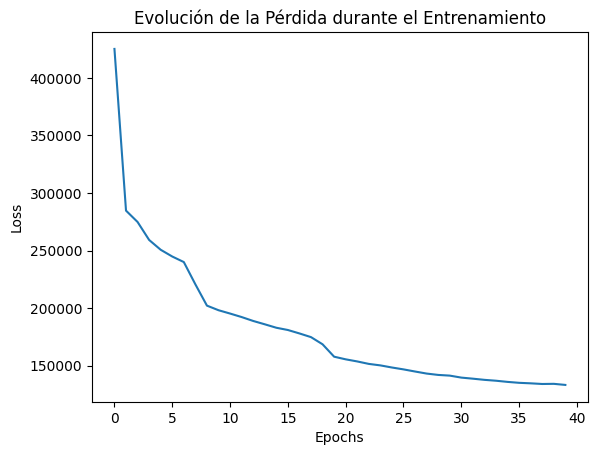

In [ ]:
sg = CBOW
min_count = 1
window = 5
vector_size = 300
negative = 20
hs = 0

(
    model_1,
    loss_history_1,
    training_time_1

    ) = trainModel(min_count=min_count, window=window, vector_size=vector_size, negative=negative, sg=sg, hs=hs, tokens_list=tokens_list, n_epochs=n_epochs)

loss_history_1.plot_loss()

#### Modelo 2

Loss after epoch 1: 2020088.125
Loss after epoch 2: 1214201.125
Loss after epoch 3: 1126448.75
Loss after epoch 4: 1052518.0
Loss after epoch 5: 1047960.5
Loss after epoch 6: 1041488.5
Loss after epoch 7: 1033748.0
Loss after epoch 8: 998984.0
Loss after epoch 9: 987748.0
Loss after epoch 10: 972652.0
Loss after epoch 11: 962493.0
Loss after epoch 12: 950061.0
Loss after epoch 13: 931792.0
Loss after epoch 14: 924112.0
Loss after epoch 15: 905547.0
Loss after epoch 16: 889120.0
Loss after epoch 17: 856884.0
Loss after epoch 18: 835990.0
Loss after epoch 19: 828230.0
Loss after epoch 20: 816810.0
Loss after epoch 21: 798692.0
Loss after epoch 22: 793590.0
Loss after epoch 23: 780810.0
Loss after epoch 24: 774490.0
Loss after epoch 25: 761620.0
Loss after epoch 26: 756642.0
Loss after epoch 27: 744692.0
Loss after epoch 28: 736806.0
Loss after epoch 29: 729444.0
Loss after epoch 30: 724756.0
Loss after epoch 31: 718706.0
Loss after epoch 32: 714878.0
Loss after epoch 33: 704110.0
Loss af

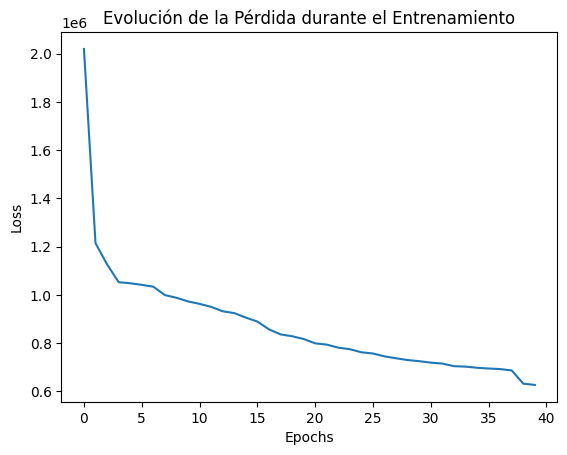

In [ ]:
sg = SKIPGRAM
min_count = 1
window = 5
vector_size = 300
negative = 20
hs = 0

(
    model_2,
    loss_history_2,
    training_time_2

    ) = trainModel(min_count=min_count, window=window, vector_size=vector_size, negative=negative, sg=sg, hs=hs, tokens_list=tokens_list, n_epochs=n_epochs)

loss_history_2.plot_loss()

#### Modelo 3

Loss after epoch 1: 264609.71875
Loss after epoch 2: 202717.09375
Loss after epoch 3: 200757.875
Loss after epoch 4: 200332.5
Loss after epoch 5: 197692.0625
Loss after epoch 6: 173250.875
Loss after epoch 7: 171341.75
Loss after epoch 8: 169410.25
Loss after epoch 9: 168139.0
Loss after epoch 10: 166307.625
Loss after epoch 11: 164909.375
Loss after epoch 12: 145170.125
Loss after epoch 13: 141864.75
Loss after epoch 14: 141156.0
Loss after epoch 15: 139592.25
Loss after epoch 16: 138488.75
Loss after epoch 17: 136939.0
Loss after epoch 18: 136039.5
Loss after epoch 19: 135076.5
Loss after epoch 20: 133586.75
Loss after epoch 21: 133154.25
Loss after epoch 22: 131689.75
Loss after epoch 23: 130968.25
Loss after epoch 24: 130171.0
Loss after epoch 25: 129256.75
Loss after epoch 26: 128569.0
Loss after epoch 27: 124515.25
Loss after epoch 28: 116643.5
Loss after epoch 29: 116249.5
Loss after epoch 30: 115349.5
Loss after epoch 31: 114680.0
Loss after epoch 32: 113714.5
Loss after epoch 

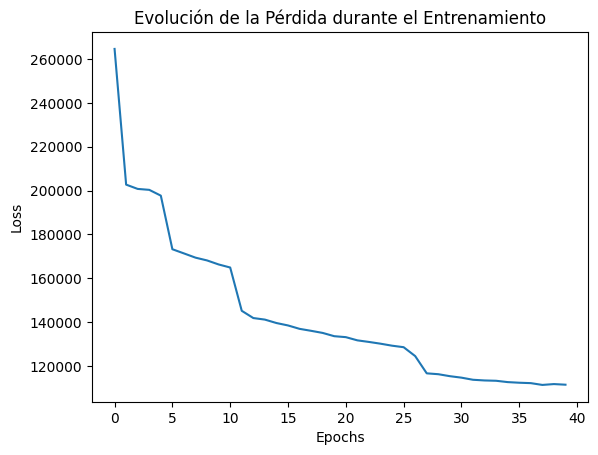

In [ ]:
sg = CBOW
min_count = 5
window = 5
vector_size = 300
negative = 20
hs = 0

(
    model_3,
    loss_history_3,
    training_time_3

    ) = trainModel(min_count=min_count, window=window, vector_size=vector_size, negative=negative, sg=sg, hs=hs, tokens_list=tokens_list, n_epochs=n_epochs)

loss_history_3.plot_loss()

#### Modelo 4

Loss after epoch 1: 1241575.75
Loss after epoch 2: 984177.75
Loss after epoch 3: 887775.75
Loss after epoch 4: 881017.5
Loss after epoch 5: 834583.75
Loss after epoch 6: 820506.0
Loss after epoch 7: 817161.0
Loss after epoch 8: 810181.5
Loss after epoch 9: 808224.5
Loss after epoch 10: 791897.5
Loss after epoch 11: 772741.0
Loss after epoch 12: 766113.0
Loss after epoch 13: 761852.0
Loss after epoch 14: 759992.0
Loss after epoch 15: 754274.0
Loss after epoch 16: 748941.0
Loss after epoch 17: 744031.0
Loss after epoch 18: 740416.0
Loss after epoch 19: 736662.0
Loss after epoch 20: 732263.0
Loss after epoch 21: 721822.0
Loss after epoch 22: 711770.0
Loss after epoch 23: 708772.0
Loss after epoch 24: 708696.0
Loss after epoch 25: 705714.0
Loss after epoch 26: 702064.0
Loss after epoch 27: 697220.0
Loss after epoch 28: 692446.0
Loss after epoch 29: 691770.0
Loss after epoch 30: 691692.0
Loss after epoch 31: 688242.0
Loss after epoch 32: 685414.0
Loss after epoch 33: 687272.0
Loss after epo

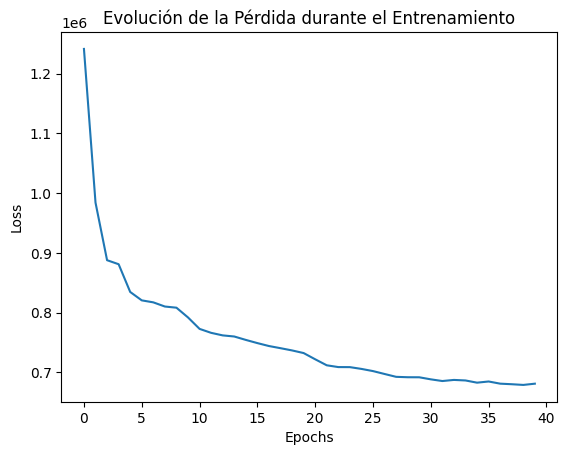

In [ ]:
sg = SKIPGRAM
min_count = 5
window = 5
vector_size = 300
negative = 20
hs = 0

(
    model_4,
    loss_history_4,
    training_time_4

    ) = trainModel(min_count=min_count, window=window, vector_size=vector_size, negative=negative, sg=sg, hs=hs, tokens_list=tokens_list, n_epochs=n_epochs)

loss_history_4.plot_loss()

#### Modelo 5

Loss after epoch 1: 293508.78125
Loss after epoch 2: 203057.78125
Loss after epoch 3: 201151.8125
Loss after epoch 4: 200992.5
Loss after epoch 5: 194303.0
Loss after epoch 6: 172409.25
Loss after epoch 7: 168260.5
Loss after epoch 8: 165166.0
Loss after epoch 9: 162749.875
Loss after epoch 10: 159832.25
Loss after epoch 11: 157796.875
Loss after epoch 12: 140198.875
Loss after epoch 13: 136739.0
Loss after epoch 14: 135254.0
Loss after epoch 15: 133636.25
Loss after epoch 16: 131885.5
Loss after epoch 17: 130488.5
Loss after epoch 18: 129105.5
Loss after epoch 19: 127170.0
Loss after epoch 20: 126219.0
Loss after epoch 21: 124581.25
Loss after epoch 22: 123909.0
Loss after epoch 23: 122928.75
Loss after epoch 24: 121611.75
Loss after epoch 25: 119988.5
Loss after epoch 26: 119618.25
Loss after epoch 27: 118255.0
Loss after epoch 28: 114715.25
Loss after epoch 29: 107949.0
Loss after epoch 30: 107027.0
Loss after epoch 31: 107390.5
Loss after epoch 32: 105840.5
Loss after epoch 33: 105

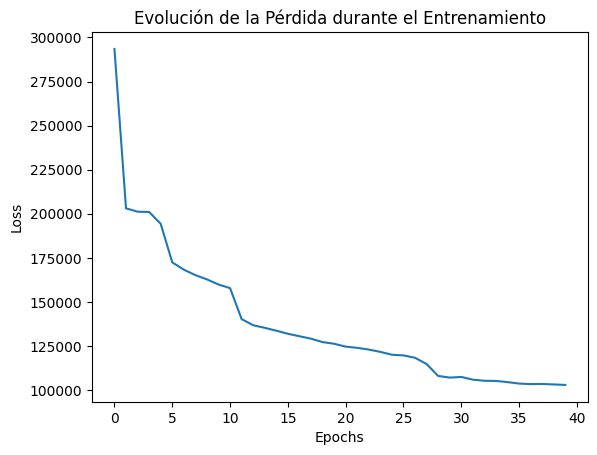

In [ ]:
sg = CBOW
min_count = 5
window = 2
vector_size = 300
negative = 20
hs = 0

(
    model_5,
    loss_history_5,
    training_time_5

    ) = trainModel(min_count=min_count, window=window, vector_size=vector_size, negative=negative, sg=sg, hs=hs, tokens_list=tokens_list, n_epochs=n_epochs)

loss_history_5.plot_loss()

#### Modelo 6

Loss after epoch 1: 748245.3125
Loss after epoch 2: 552587.3125
Loss after epoch 3: 509711.5
Loss after epoch 4: 476899.125
Loss after epoch 5: 437284.5
Loss after epoch 6: 437784.75
Loss after epoch 7: 434034.75
Loss after epoch 8: 431396.25
Loss after epoch 9: 412711.0
Loss after epoch 10: 399015.0
Loss after epoch 11: 396693.0
Loss after epoch 12: 392237.0
Loss after epoch 13: 391278.0
Loss after epoch 14: 387939.0
Loss after epoch 15: 385725.5
Loss after epoch 16: 383391.5
Loss after epoch 17: 379120.5
Loss after epoch 18: 376997.5
Loss after epoch 19: 371437.0
Loss after epoch 20: 358210.5
Loss after epoch 21: 351321.0
Loss after epoch 22: 348328.0
Loss after epoch 23: 346425.0
Loss after epoch 24: 344969.0
Loss after epoch 25: 341090.0
Loss after epoch 26: 340495.0
Loss after epoch 27: 338438.0
Loss after epoch 28: 337035.0
Loss after epoch 29: 333752.0
Loss after epoch 30: 333216.0
Loss after epoch 31: 333499.0
Loss after epoch 32: 330347.0
Loss after epoch 33: 328461.0
Loss aft

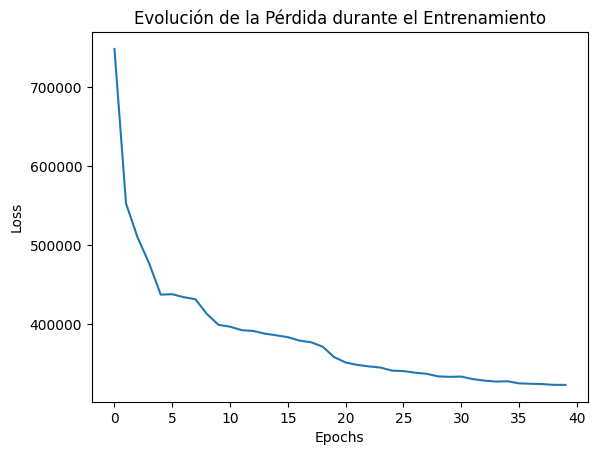

In [ ]:
sg = SKIPGRAM
min_count = 5
window = 2
vector_size = 300
negative = 20
hs = 0

(
    model_6,
    loss_history_6,
    training_time_6

    ) = trainModel(min_count=min_count, window=window, vector_size=vector_size, negative=negative, sg=sg, hs=hs, tokens_list=tokens_list, n_epochs=n_epochs)

loss_history_6.plot_loss()

#### Modelo 7

Loss after epoch 1: 262362.375
Loss after epoch 2: 202673.96875
Loss after epoch 3: 200724.78125
Loss after epoch 4: 200043.3125
Loss after epoch 5: 197192.3125
Loss after epoch 6: 172473.375
Loss after epoch 7: 170575.5
Loss after epoch 8: 168433.75
Loss after epoch 9: 166983.5
Loss after epoch 10: 164939.0
Loss after epoch 11: 163303.125
Loss after epoch 12: 144989.75
Loss after epoch 13: 140509.75
Loss after epoch 14: 139650.25
Loss after epoch 15: 137991.25
Loss after epoch 16: 136834.0
Loss after epoch 17: 135241.75
Loss after epoch 18: 134433.0
Loss after epoch 19: 133406.5
Loss after epoch 20: 131941.75
Loss after epoch 21: 131494.25
Loss after epoch 22: 130122.75
Loss after epoch 23: 129356.0
Loss after epoch 24: 128634.0
Loss after epoch 25: 127768.25
Loss after epoch 26: 127143.0
Loss after epoch 27: 125538.25
Loss after epoch 28: 115082.0
Loss after epoch 29: 114712.0
Loss after epoch 30: 113958.0
Loss after epoch 31: 113308.5
Loss after epoch 32: 112278.0
Loss after epoch 3

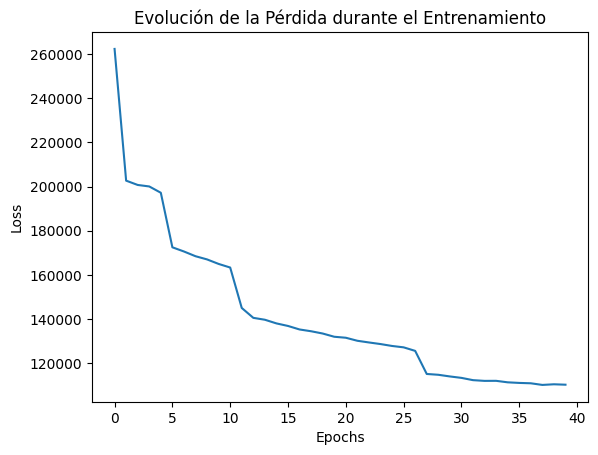

In [ ]:
sg = CBOW
min_count = 5
window = 5
vector_size = 100
negative = 20
hs = 0

(
    model_7,
    loss_history_7,
    training_time_7

    ) = trainModel(min_count=min_count, window=window, vector_size=vector_size, negative=negative, sg=sg, hs=hs, tokens_list=tokens_list, n_epochs=n_epochs)

loss_history_7.plot_loss()

#### Modelo 8

Loss after epoch 1: 1237577.125
Loss after epoch 2: 983753.875
Loss after epoch 3: 886920.75
Loss after epoch 4: 879625.5
Loss after epoch 5: 832932.25
Loss after epoch 6: 818081.5
Loss after epoch 7: 814604.5
Loss after epoch 8: 807761.5
Loss after epoch 9: 805883.5
Loss after epoch 10: 789844.5
Loss after epoch 11: 770208.0
Loss after epoch 12: 764197.0
Loss after epoch 13: 760747.0
Loss after epoch 14: 760033.0
Loss after epoch 15: 755123.0
Loss after epoch 16: 750722.0
Loss after epoch 17: 747382.0
Loss after epoch 18: 744984.0
Loss after epoch 19: 743021.0
Loss after epoch 20: 739529.0
Loss after epoch 21: 731231.0
Loss after epoch 22: 724014.0
Loss after epoch 23: 722408.0
Loss after epoch 24: 724194.0
Loss after epoch 25: 722516.0
Loss after epoch 26: 720298.0
Loss after epoch 27: 717256.0
Loss after epoch 28: 713018.0
Loss after epoch 29: 712994.0
Loss after epoch 30: 714424.0
Loss after epoch 31: 712748.0
Loss after epoch 32: 710202.0
Loss after epoch 33: 713962.0
Loss after e

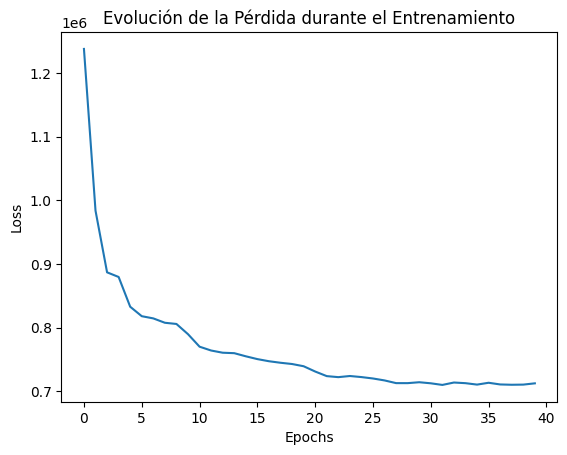

In [ ]:
sg = SKIPGRAM
min_count = 5
window = 5
vector_size = 100
negative = 20
hs = 0

(
    model_8,
    loss_history_8,
    training_time_8

    ) = trainModel(min_count=min_count, window=window, vector_size=vector_size, negative=negative, sg=sg, hs=hs, tokens_list=tokens_list, n_epochs=n_epochs)

loss_history_8.plot_loss()

#### Modelo 9

Loss after epoch 1: 332635.8125
Loss after epoch 2: 328465.5
Loss after epoch 3: 327156.4375
Loss after epoch 4: 325280.75
Loss after epoch 5: 322424.25
Loss after epoch 6: 318881.5
Loss after epoch 7: 316292.25
Loss after epoch 8: 312339.5
Loss after epoch 9: 308165.5
Loss after epoch 10: 304228.75
Loss after epoch 11: 300912.25
Loss after epoch 12: 297161.0
Loss after epoch 13: 294040.5
Loss after epoch 14: 289309.5
Loss after epoch 15: 284611.5
Loss after epoch 16: 281358.0
Loss after epoch 17: 278790.5
Loss after epoch 18: 275800.5
Loss after epoch 19: 273562.0
Loss after epoch 20: 270442.0
Loss after epoch 21: 268656.5
Loss after epoch 22: 265676.0
Loss after epoch 23: 263622.0
Loss after epoch 24: 261941.0
Loss after epoch 25: 259874.0
Loss after epoch 26: 257947.5
Loss after epoch 27: 256729.0
Loss after epoch 28: 253896.5
Loss after epoch 29: 252666.5
Loss after epoch 30: 242193.0
Loss after epoch 31: 240680.0
Loss after epoch 32: 239250.0
Loss after epoch 33: 238535.0
Loss aft

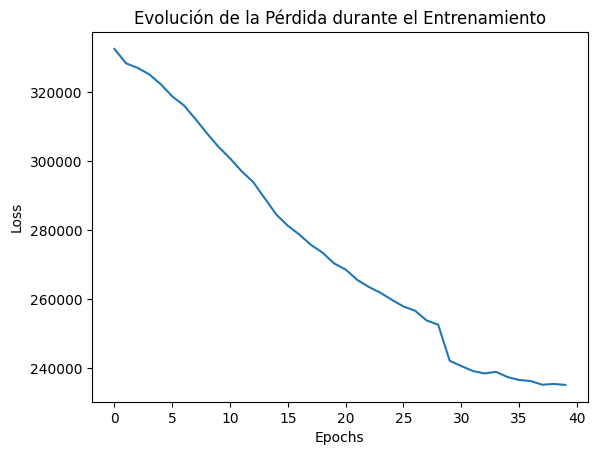

In [ ]:
sg = CBOW
min_count = 5
window = 5
vector_size = 100
negative = 0
hs = 1

(
    model_9,
    loss_history_9,
    training_time_9

    ) = trainModel(min_count=min_count, window=window, vector_size=vector_size, negative=negative, sg=sg, hs=hs, tokens_list=tokens_list, n_epochs=n_epochs)

loss_history_9.plot_loss()

#### Modelo 10

Loss after epoch 1: 1971390.75
Loss after epoch 2: 1964309.5
Loss after epoch 3: 1864243.75
Loss after epoch 4: 1852207.0
Loss after epoch 5: 2064162.0
Loss after epoch 6: 2139808.0
Loss after epoch 7: 2084530.0
Loss after epoch 8: 2025174.0
Loss after epoch 9: 1184145.0
Loss after epoch 10: 650520.0
Loss after epoch 11: 665300.0
Loss after epoch 12: 672350.0
Loss after epoch 13: 678542.0
Loss after epoch 14: 683430.0
Loss after epoch 15: 682872.0
Loss after epoch 16: 685916.0
Loss after epoch 17: 683812.0
Loss after epoch 18: 677926.0
Loss after epoch 19: 674628.0
Loss after epoch 20: 668338.0
Loss after epoch 21: 664666.0
Loss after epoch 22: 664452.0
Loss after epoch 23: 654692.0
Loss after epoch 24: 651126.0
Loss after epoch 25: 639944.0
Loss after epoch 26: 634620.0
Loss after epoch 27: 625140.0
Loss after epoch 28: 620684.0
Loss after epoch 29: 608982.0
Loss after epoch 30: 604832.0
Loss after epoch 31: 594256.0
Loss after epoch 32: 581680.0
Loss after epoch 33: 575214.0
Loss aft

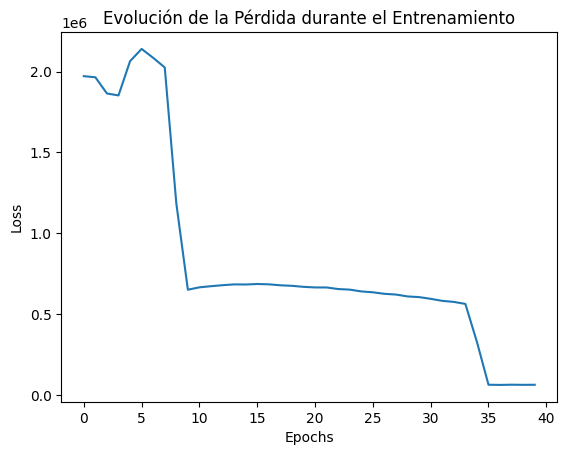

In [ ]:
sg = SKIPGRAM
min_count = 5
window = 5
vector_size = 100
negative = 0
hs = 1

(
    model_10,
    loss_history_10,
    training_time_10

    ) = trainModel(min_count=min_count, window=window, vector_size=vector_size, negative=negative, sg=sg, hs=hs, tokens_list=tokens_list, n_epochs=n_epochs)

loss_history_10.plot_loss()

### Conclusiones

#### Aprendizaje

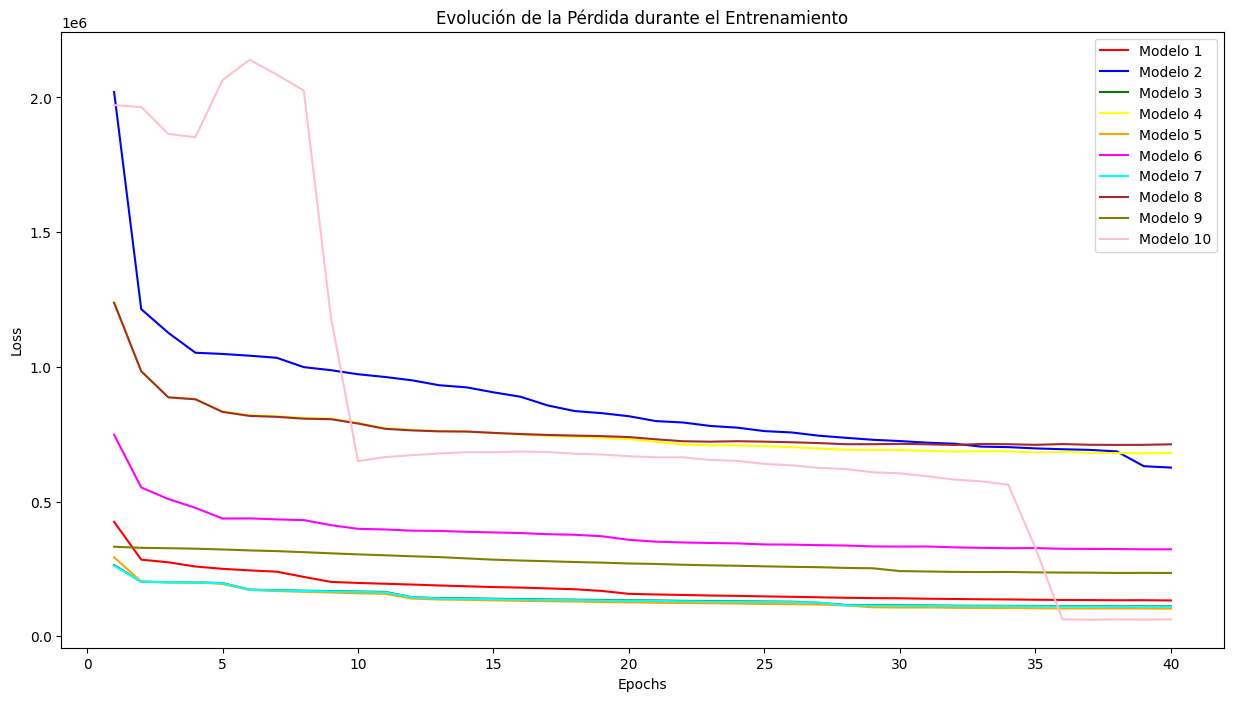

In [ ]:
x = range(1, n_epochs + 1)
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'magenta', 'cyan', 'brown', 'olive', 'pink']
plt.figure(figsize=(15, 8))

# Iterar del 1 al 10 y acceder a loss_history_X.losses
for i in range(1, 11):

  loss_history_object = globals().get(f"loss_history_{i}")

  plt.plot(x, loss_history_object.losses, label=f"Modelo {i}", color=colors[i-1])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.legend()
plt.show()

La función de pérdida mide qué tan bien el modelo está aprendiendo las representaciones vectoriales de las palabras.  
El objetivo es minimizar esta función de pérdida a través de la optimización, lo que lleva a embeddings que capturan las relaciones semánticas entre las palabras de manera eficaz.  

Los modelos que llegaron a valores menores de la función de pérdida fueron, en su mayoría, los que fueron entrenados con sg=0 (CBOW) [1, 3, 5, 7, 9].

CBOW suele ser más rápido para converger, lo que significa que su función de pérdida tiende a estabilizarse más rápido.

Skip-gram, en cambio, requiere más tiempo y ajustes debido a que el modelo está intentando predecir varias palabras a partir de una sola palabra central. El modelo necesita más pasos de optimización para ajustar correctamente los pesos.

Se observa que el modelo 10, (Skip-gram con hs=1), sí logra una convergencia mucho más rápida.  
El uso de Hierarchical Softmax (hs=1), hace que el número de operaciones necesarias para calcular la función de pérdida se reduzca considerablemente. En lugar de calcular las probabilidades de todas las palabras del vocabulario, solo se recorre el árbol binario para obtener la probabilidad de la palabra predicha.  
Esto significa que el modelo puede procesar y actualizar los pesos más rápidamente, lo que puede llevar a una convergencia más rápida durante el entrenamiento.

#### Tiempo de entrenamiento

In [ ]:
training_times = [globals().get(f'training_time_{i}') for i in range(1, 11) if globals().get(f'training_time_{i}') is not None]

model_ids = [f"Modelo {i}" for i in range(1, 11)]

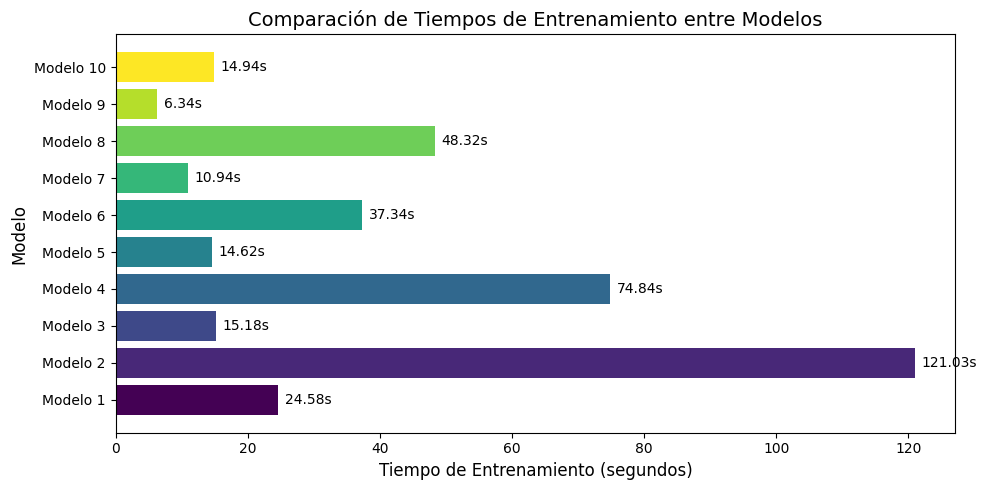

In [ ]:
plt.figure(figsize=(10, 5))
colors = plt.cm.viridis(np.linspace(0, 1, len(training_times)))
plt.barh(model_ids, training_times, color=colors)

plt.title('Comparación de Tiempos de Entrenamiento entre Modelos', fontsize=14)
plt.xlabel('Tiempo de Entrenamiento (segundos)', fontsize=12)
plt.ylabel('Modelo', fontsize=12)

for i, t in enumerate(training_times):
    plt.text(t + 1, i, f'{t:.2f}s', va='center', fontsize=10)

plt.tight_layout()
plt.show()


Se observa que los modelos entrenados con SKIPGRAM tardan más que los entrenados con CBOW a igualdad del resto de los parámetros.  
Esto era esperable ya que con SKIPGRAM, para cada palabra objetivo, el modelo tiene que generar predicciones para todas las palabras del contexto, lo que implica más cálculos.  CBOW suele ser más rápido porque predice una única palabra objetivo a partir de un conjunto de palabras. Esto reduce la complejidad del proceso.

In [ ]:
# Parámetros de los modelos entrenados
train_params = {
    'CBOW': [],
    'Skip-gram': []
}

for i in range(1, 11):

  model_i = globals().get(f'model_{i}')

  sg = "Skip-gram" if model_i.sg == 1 else "CBOW"

  train_params[sg].append({
      'model': i,
      'min_count': model_i.min_count,
      'window': model_i.window,
      'vector_size': model_i.vector_size,
      'negative': model_i.negative,
      'time': training_times[i-1]
  })


Tomo por separado los modelos CBOW y Skip-gram para explorar la relación entre los otros parámetros y el tiempo de entrenamiento.

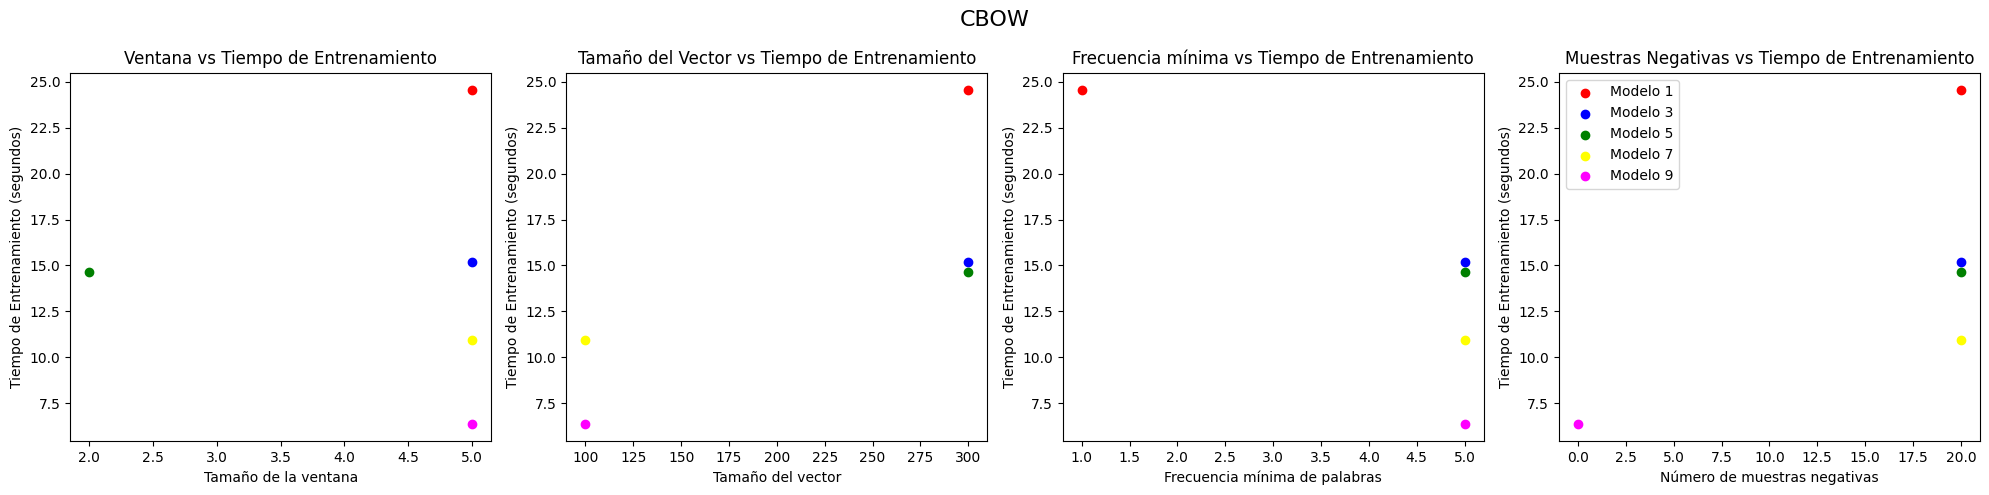

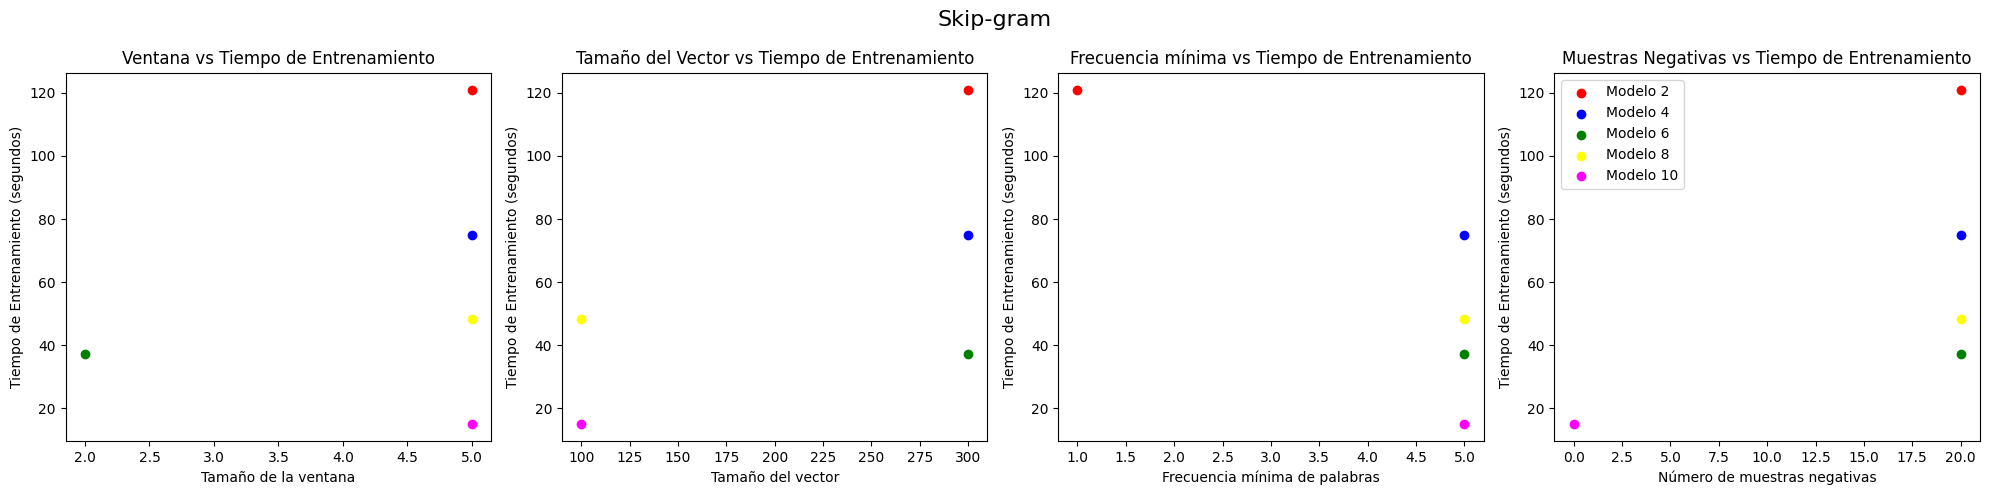

In [ ]:
for model_sg in ['CBOW', 'Skip-gram']:

  model_numbers = [model['model'] for model in train_params[model_sg]]

  train_times = [model['time'] for model in train_params[model_sg]]

  window_sizes = [model['window'] for model in train_params[model_sg]]
  vector_sizes = [model['vector_size'] for model in train_params[model_sg]]
  min_counts = [model['min_count'] for model in train_params[model_sg]]
  negative_samples = [model['negative'] for model in train_params[model_sg]]


  # Gráficos de dispersión
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
  colors = ['red', 'blue', 'green', 'yellow', 'magenta']

  plt.suptitle(model_sg, fontsize=16)

  # Gráfico 1: Relación entre tamaño de ventana y tiempo de entrenamiento
  for i, (x, y, p) in enumerate(zip(window_sizes, train_times, model_numbers)):
    ax1.scatter(x, y, color=colors[i], label=f'Modelo {p}')

  ax1.set_title('Ventana vs Tiempo de Entrenamiento')
  ax1.set_xlabel('Tamaño de la ventana')
  ax1.set_ylabel('Tiempo de Entrenamiento (segundos)')

  # Gráfico 2: Relación entre tamaño del vector y tiempo de entrenamiento
  for i, (x, y, p) in enumerate(zip(vector_sizes, train_times, model_numbers)):
    ax2.scatter(x, y, color=colors[i], label=f'Modelo {p}')

  ax2.set_title('Tamaño del Vector vs Tiempo de Entrenamiento')
  ax2.set_xlabel('Tamaño del vector')
  ax2.set_ylabel('Tiempo de Entrenamiento (segundos)')

  # Gráfico 3: Relación entre frecuencia mínima y tiempo de entrenamiento
  for i, (x, y, p) in enumerate(zip(min_counts, train_times, model_numbers)):
    ax3.scatter(x, y, color=colors[i], label=f'Modelo {p}')

  ax3.set_title('Frecuencia mínima vs Tiempo de Entrenamiento')
  ax3.set_xlabel('Frecuencia mínima de palabras')
  ax3.set_ylabel('Tiempo de Entrenamiento (segundos)')

  # Gráfico 4: Relación entre muestras negativas y tiempo de entrenamiento
  for i, (x, y, p) in enumerate(zip(negative_samples, train_times, model_numbers)):
    ax4.scatter(x, y, color=colors[i], label=f'Modelo {p}')

  ax4.set_title('Muestras Negativas vs Tiempo de Entrenamiento')
  ax4.set_xlabel('Número de muestras negativas')
  ax4.set_ylabel('Tiempo de Entrenamiento (segundos)')

  plt.legend()
  plt.tight_layout()
  plt.show()


Los gráficos de dispersión comparando la variación de los parámetros con relación al tiempo de entrenamiento necesario indican que:  

* **Tamaño del vector**:  
 * Más dimensiones significan que el modelo tiene más parámetros que ajustar durante el entrenamiento. Esto generalmente aumenta el tiempo de entrenamiento porque se necesita más tiempo para actualizar los parámetros durante el proceso de optimización.  
Con un vector más grande, el modelo tiene más capacidad para representar relaciones más complejas entre las palabras, lo que puede resultar en una mejor calidad de los embeddings.  
 * Si el tamaño del vector es más pequeño, el modelo tendrá menos parámetros que ajustar, lo que puede acelerar el tiempo de entrenamiento.  
 Sin embargo, un tamaño de vector demasiado pequeño podría hacer que el modelo no tenga suficiente capacidad para capturar la riqueza semántica de las palabras, lo que podría resultar en embeddings de menor calidad.


 * **Tamaño de la ventana**:  
  * Al aumentar el tamaño de la ventana, el modelo toma más palabras de contexto para aprender la representación de la palabra central (en CBOW) o intenta predecir más palabras de contexto (en Skip-Gram).  
   Esto puede hacer que el entrenamiento sea más lento, ya que hay más combinaciones de contexto y objetivo que procesar.  
   Con una ventana más grande, se pueden generar más relaciones semánticas y contextuales entre las palabras, lo que puede mejorar la calidad de los embeddings, pero también incrementa el tiempo de entrenamiento.  
  * Si la ventana es más pequeña, el modelo aprenderá representaciones más locales de las palabras, lo que puede reducir el tiempo de entrenamiento.   
  Sin embargo, esto podría perder información más global o contextual que podría ser útil para algunas tareas específicas.


* **Frecuencia mínima**:
 * Si el valor de min_count es alto, solo las palabras más frecuentes (que aparecen muchas veces en el corpus) se incluyen en el vocabulario.  
 Las palabras poco frecuentes (que aparecen solo unas pocas veces) se ignoran. Esto reduce el tamaño del vocabulario, lo que puede acelerar el entrenamiento, ya que el modelo no tiene que aprender representaciones para estas palabras raras.  
 Además, la reducción del vocabulario significa que el modelo tendrá menos combinaciones de contexto-palabra objetivo a procesar, lo que puede disminuir el tiempo de entrenamiento.
 * Si min_count se establece en un valor bajo, el modelo incluirá incluso las palabras muy raras en el vocabulario.  
 Esto incrementa el tamaño del vocabulario y, por lo tanto, aumenta el tiempo de entrenamiento, ya que el modelo tendrá que procesar una mayor cantidad de datos y representar más palabras.

* **Muestras negativas**:  
 * Al aumentar el número de muestras negativas, cada vez que el modelo realiza una actualización de los pesos, tendrá que calcular la actualización para más ejemplos negativos.   
 Esto aumenta el tiempo de entrenamiento, porque el modelo tiene que realizar más cálculos en cada iteración de optimización.  
 * Un número alto de muestras negativas mejora la calidad de los embeddings, pero aumenta el tiempo de entrenamiento, por el contrario, un número bajo de muestras negativas acelera el entrenamiento, pero puede reducir la calidad de los embeddings.

#### Similitudes entre palabras

Selecciono palabras para evaluar el desempeño de los modelos en cuanto a similaridad en los términos aprendidos.

In [ ]:
# Obtener similaridad positiva, negativa o ambas
def getSimilarWords(model, positive=[], negative=[], topn=10):

  return model.wv.most_similar(positive=positive, negative=negative, topn=topn)

In [ ]:
# Lista de modelos ya entrenados
w_models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9, model_10]

In [ ]:
def printSimilarWords(words, words_n=[], topn=10, both=0):
  """
  Imprime nube de palabras similares
  both = 0 => imprime a partir de words las topn palabras más cercanas o menos cercanas a las palabras dadas
  both = 1 => combina palabras positivas y negativas y devuelve una sola gráfica
  """

  all_results = {}
  global w_models

  # Iterar sobre los modelos
  for i, model in enumerate(w_models, start=1):

      # Resultados por modelo [positivos, negativos]
      if both == 0:
        all_results[f"Modelo_{i}"] = [getSimilarWords(model, words, [], topn=topn), getSimilarWords(model, [], words, topn=topn)]
        cols = 4
        title = 'Referencia: ' + str(words)
        colormap = 'Greens'
      else:
        all_results[f"Modelo_{i}"] = [getSimilarWords(model, words, words_n, topn=topn)]
        cols = 2
        title = 'Referencia: + ' + str(words) + ' - ' + str(words_n)
        colormap = 'viridis'

  # Nubes de palabras
  fig, axes = plt.subplots(len(all_results), cols, figsize=(5* cols, 5 * len(all_results)))

  plt.suptitle(title, fontsize=18)

  # Iterar sobre los modelos en el diccionario
  for i, (model_name, model_data) in enumerate(all_results.items()):

      positive_words = model_data[0]
      positive_freq = {word: similarity for word, similarity in positive_words}

      # Crear la nube de palabras para las palabras positivas
      wordcloud_positive = WordCloud(width=200, height=100, background_color='white', colormap=colormap).generate_from_frequencies(positive_freq)

      # Convertir las listas de palabras y similitudes en un DataFrame para mostrar en tabla
      df_positive = pd.DataFrame(positive_words, columns=["Palabra", "Similitud"])

      # Formato 4 decimales
      df_positive["Similitud"] = df_positive["Similitud"].apply(lambda x: f"{x:.4f}")


      # Mostrar la nube de palabras positivas
      axes[i, 0].imshow(wordcloud_positive, interpolation='bilinear')
      axes[i, 0].axis('off')
      axes[i, 0].set_title(f"Modelo {i+1} - Palabras más cercanas", fontsize=14)

      # Tabla de palabras positivas
      axes[i, 1].axis('tight')
      axes[i, 1].axis('off')
      table_positive = axes[i, 1].table(cellText=df_positive.values, colLabels=df_positive.columns, loc='center', cellLoc='center', colLoc='center')

      # Ajuste de formato de la tabla
      table_positive.auto_set_font_size(False)  # Desactivar el ajuste automático
      table_positive.set_fontsize(12)
      for (pi, pj), cell in table_positive.get_celld().items():
          if pi == 0:  # Encabezados
              cell.set_fontsize(14)
              cell.set_text_props(weight='bold')
              cell.set_facecolor('#CCCCCC')
          else:
              cell.set_fontsize(12)
              cell.set_facecolor('#FFFFFF')
              cell.set_edgecolor('black')
      table_positive.auto_set_column_width([0, 1])  # Ajuste automático del ancho de las columnas

      if both == 0:
          negative_words = model_data[1]
          negative_freq = {word: similarity for word, similarity in negative_words}
          wordcloud_negative = WordCloud(width=200, height=100, background_color='white', colormap='Reds').generate_from_frequencies(negative_freq)
          df_negative = pd.DataFrame(negative_words, columns=["Palabra", "Similitud"])
          df_negative["Similitud"] = df_negative["Similitud"].apply(lambda x: f"{x:.4f}")

          # Mostrar la nube de palabras negativas
          axes[i, 2].imshow(wordcloud_negative, interpolation='bilinear')
          axes[i, 2].axis('off')
          axes[i, 2].set_title(f"Modelo {i+1} - Palabras menos cercanas", fontsize=14)

          # Tabla de palabras negativas
          axes[i, 3].axis('tight')
          axes[i, 3].axis('off')
          table_negative = axes[i, 3].table(cellText=df_negative.values, colLabels=df_negative.columns, loc='center', cellLoc='center', colLoc='center')

          # Ajuste de formato de la tabla
          table_negative.auto_set_font_size(False)  # Desactivar el ajuste automático
          table_negative.set_fontsize(12)
          for (ni, nj), cell in table_negative.get_celld().items():
              if ni == 0:  # Encabezados
                  cell.set_fontsize(14)
                  cell.set_text_props(weight='bold')
                  cell.set_facecolor('#CCCCCC')
              else:
                  cell.set_fontsize(12)
                  cell.set_facecolor('#FFFFFF')
                  cell.set_edgecolor('black')
          table_negative.auto_set_column_width([0, 1])  # Ajuste automático del ancho de las columnas

  plt.tight_layout()
  plt.show()


Las 10 palabras más cercanas a "pobre":

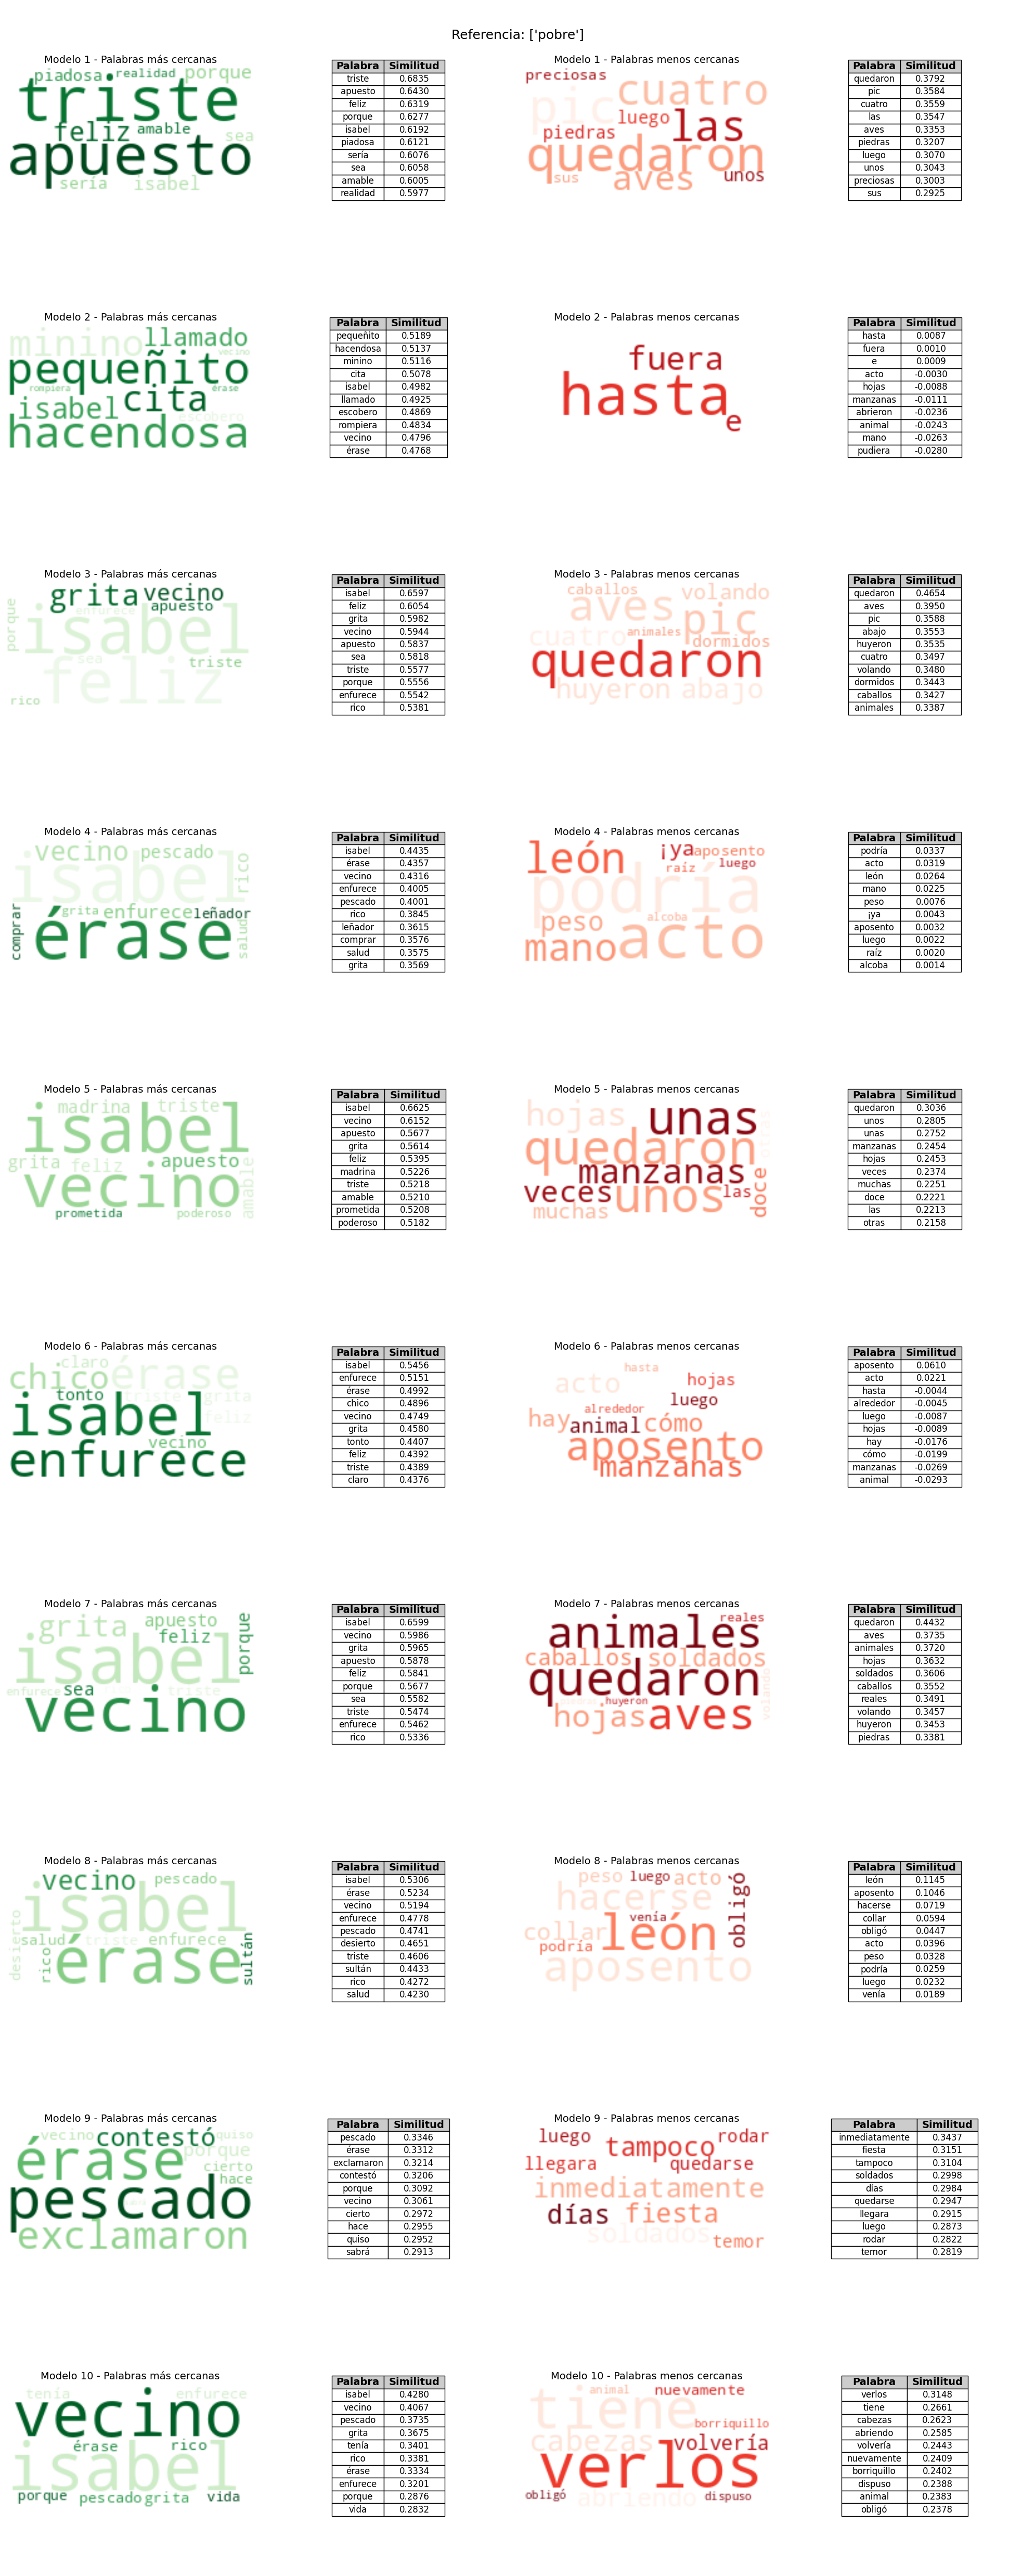

In [ ]:
printSimilarWords( ['pobre'], 10)

Se observa que muchos de los modelos encuentran como cercana a "pobre" las palabras "isabel", "vecino", "pescado" que parecieran no tener relación semántica directa.

Analizando el corpus, esto deriva del cuento "El pescador y su mujer", donde se repite varias veces el párrafo "... hermoso pescado, pequeño vecino,
mi pobre Isabel grita y se enfurece ...", por lo que, es esperable que reconozca estos términos como cercanos.

Los embeddings de palabras miden la similitud contextual de las palabras basándose en cómo se usan en los textos. Cuanto más frecuentemente dos palabras aparecen en contextos similares, más cercanas estarán en el espacio vectorial.

Por lo tanto, al calcular la similitud de palabras, lo que realmente se está midiendo es cuán cercanas están las palabras en ese espacio vectorial.   
Esta cercanía generalmente corresponde a una alta similitud semántica o contextual en el corpus de entrenamiento, pero no necesariamente siempre refleja la idea de parecerse de una manera semánticamente precisa como un ser humano podría interpretarlo.


Evalúo ahora las 10 palabras más cercanas a "pobre" pero no cercanas a "rico":

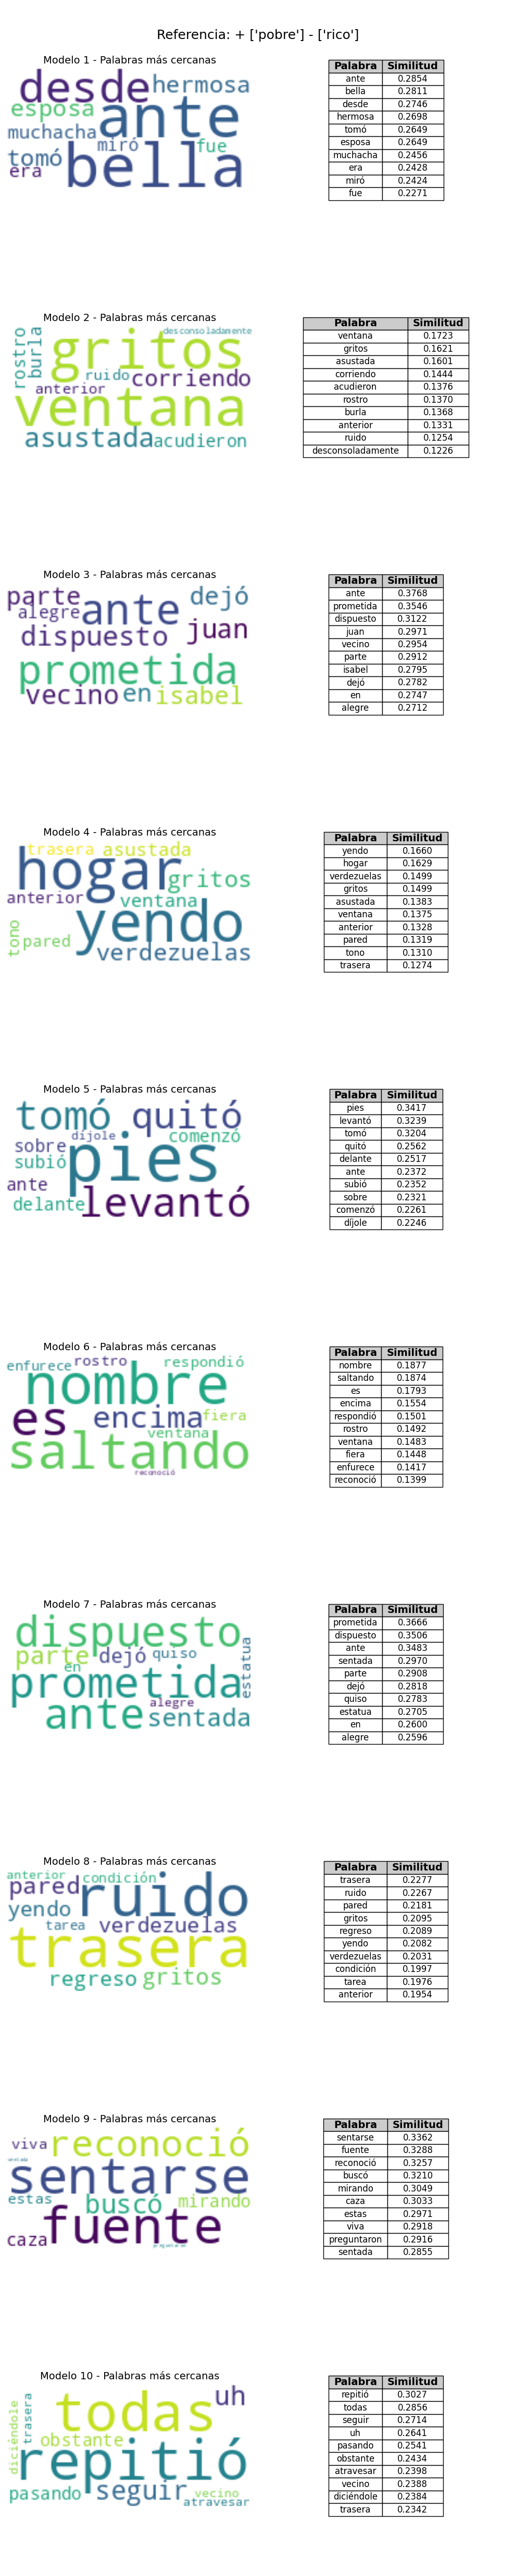

In [ ]:
printSimilarWords( ['pobre'], ['rico'], 10, both=1)

Evalúo cercanía a más de una palabra, por ejemplo, "mañana" y "sol":

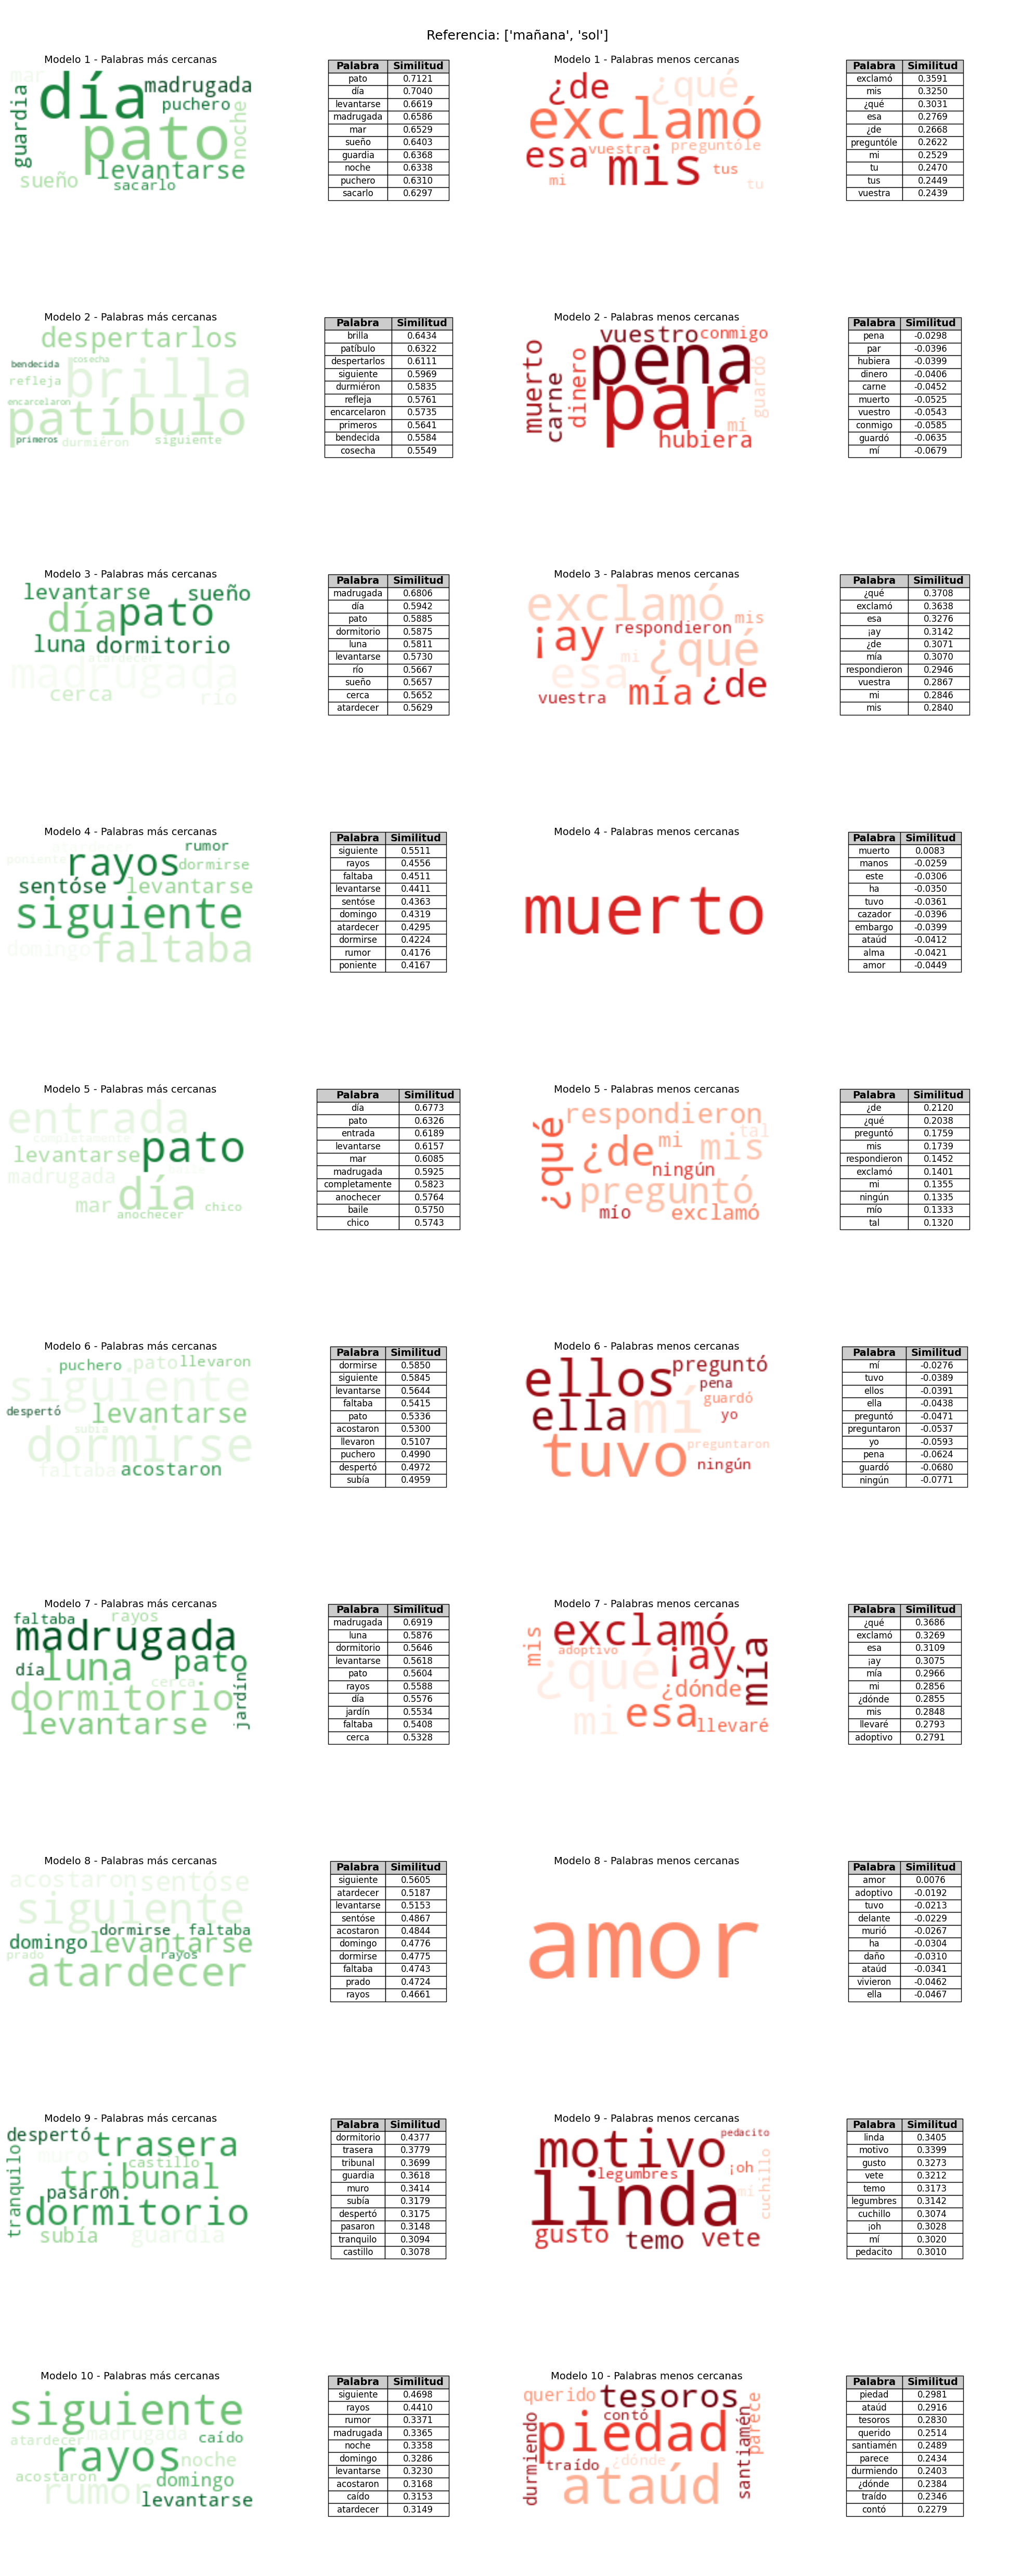

In [ ]:
printSimilarWords( ['mañana', 'sol'], [], 10, both=0)

Al consultar palabras cercanas a "mañana" y "sol", se observan algunos hallazgos interesantes en términos de similaridad contextual y semántica, por ejemplo:
* levantarse
* madrugada
* rayos
* despertó
* día
* brilla
* refleja  


que son palabras que intuitivamente podrían ser relacionadas a las utilizadas como input en muchos contextos.



#### Pruebas de analogías

In [ ]:
def analogyTest(words):

  # "word1 es a word2 como word3 es a...?"
  # vector(2) - vector(1) + vector(3)

  global w_models
  results = []

  [word1, word2, word3] = words
  print(f"Analogía '{word1} : {word2} :: {word3} : ? \n'")

  for i, model in enumerate(w_models, start=1):

    [(result1, similarity1),
     (result2, similarity2),
     (result3, similarity3)
     ] = model.wv.most_similar(positive=[word2, word3], negative=[word1], topn=3)

    results.append([f'Modelo {i}',
                    result1, f'{similarity1:.4f}',
                    result2, f'{similarity2:.4f}',
                    result3, f'{similarity3:.4f}'])

  test_df = pd.DataFrame(results)

  display(test_df.style.hide(axis='index').hide(axis='columns'))

Ejemplos Tests de analogía:

* Ejemplo 1 - Relación de género:   
"rey" es a "hombre" cómo "reina" es a "*mujer*".


In [ ]:
analogyTest(['rey', 'hombre', 'reina'])

Analogía 'rey : hombre :: reina : ? 
'


Se observa que el Modelo 1 resuelve correctamente esta relación, y el Modelo 9, también, aunque en segunda instancia.

Varios de los modelos resolvieron esta analogía con la palabra "emperatriz".
Esto sugiere que el modelo podría estar entendiendo no simplemente una relación de género, si no, una relación de título o rango.
Por ejemplo,  "emperatriz" es un título real que tiene una relación jerárquica o de poder con "reina", similar a cómo "rey" es un título relacionado con "hombre".


* Ejemplo 2 - Relación de pluralidad:   
"caballo" es a "caballos" cómo "pato" es a "*patos*".

In [ ]:
analogyTest(['caballo', 'caballos', 'pato'])

Analogía 'caballo : caballos :: pato : ? 
'


Ninguno de los modelos resolvió la palabra "patos".    
Sin embargo, varios devolvieron "cisnes".  
Esto sugiere que, los modelos pudieron no haber capturado estrictamente la relación linguística de singular/plural, sino, relaciones semánticas basadas en el contexto en el que las palabras aparecen en el corpus.  
"pato" y "cisne" suelen aparecer en los cuentos en contestos similares, ambas son aves acuáticas.



* Ejemplo 3 - Relaciones gramaticales:   
"buscar" es a "buscó" como "subir" es a "*subió*"

In [ ]:
analogyTest(['buscar', 'buscó', 'subir'])

Analogía 'buscar : buscó :: subir : ? 
'


Ningún modelo devuelve la palabra "subió", sin embargo, palabras tales como "cima", "cumbre", "llegó", dan idea de que el modelo en ese caso, en lugar de captar simplemente una relación de conjugación verbal, en cambio aprendió una relación semántica que vincula la acción de "subir" con destinos o resultados que comúnmente se asocian con el verbo "subir".  

* Ejemplo 4 - Relaciones de sinónimos o antónimos:  
"rico" es a "pobre" como "feliz" es a "*triste*".

In [ ]:
analogyTest(['rico', 'pobre', 'feliz'])

Analogía 'rico : pobre :: feliz : ? 
'


"bueno" es a "malo" como "pequeño" es a "*grande*".

In [ ]:
analogyTest(['bueno', 'malo', 'pequeño'])

Analogía 'bueno : malo :: pequeño : ? 
'


Se observa en este caso que los modelos no pueden indentificar claramente la relación de antónimos.  

Los modelos de word embeddings están diseñados para capturar relaciones semánticas basadas en el contexto de las palabras en el corpus de entrenamiento. Estos modelos tienden a mapear palabras a un espacio vectorial donde las palabras que aparecen en contextos similares se agrupan cerca unas de otras. Sin embargo, el concepto de antónimos no se basa necesariamente en un contexto de uso común, sino en una relación de opuestos conceptuales.  

Los antónimos no son capturados explícitamente en los vectores del modelo porque el modelo no está entrenado para reconocer relaciones de oposición, sino más bien relaciones de co-ocurrencia en el contexto.

Los antónimos no se dan con tanta frecuencia en los datos, lo que hace que el modelo no los aprenda tan fácilmente. El modelo se enfoca más en relaciones semánticas directas, como sinónimos o palabras que coocurren juntas en el mismo contexto.

In [ ]:
analogyTest(['linda', 'bella', 'pequeño'])

Analogía 'linda : bella :: pequeño : ? 
'


In [ ]:
analogyTest(['riquezas', 'oro', 'cima'])

Analogía 'riquezas : oro :: cima : ? 
'


En el caso de los sinónimos, sí se observa que varios de los modelos logran resolver la analogía.  

Por ejemplo,  

"linda" es a "bella" como "pequeño" es a:
* hombrecillo
* niño

"riquezas" es a "oro" como "cima" es a:
* cumbre
* montaña

#### Visualización

De los 10 modelos comparados y en función de su rendimiento con el corpus seleccionado, tomo el 1) para graficar resultados.

In [ ]:
# Palabras a comparar (set arbitrario de los cuentos más populares)
words = ["sol", "caperucita", "oso", "bosque", "roja", "princesa", "abuela", "diablo", "lobo", "doncella",
         "tres", "doce", "seis", "siete", "hermanos", "viejo", "viaje", "rey", "agua", "mar"]

In [ ]:
def embeddings_matrix_distance_word2vec(model, words):
    """
    Calcula las distancias (similitudes) entre los embeddings de las palabras utilizando un modelo Word2Vec,
    y genera un gráfico de matriz de distancias.

    Args:
    model (gensim.models.Word2Vec): El modelo Word2Vec entrenado.
    words (list): Lista de palabras para las que se calcularán los embeddings y sus distancias.
    """
    print("Cantidad de palabras:", len(words))

    # Obtener los embeddings de las palabras
    emb = []
    for word in words:
        if word in model.wv:
            emb.append(model.wv[word])
        else:
            emb.append(np.zeros(model.vector_size))  # Si la palabra no está en el vocabulario, usar un vector de ceros

    emb = np.array(emb)

    # Imprimir dimensiones de los embeddings
    print("Dimensiones de los embeddings:", emb.shape)

    # Calcular las distancias de coseno entre los embeddings
    dist = cosine_similarity(emb, emb)

    # Graficar la matriz de distancias
    plot_matrix_distance(words, dist)


Cantidad de palabras: 20
Dimensiones de los embeddings: (20, 300)


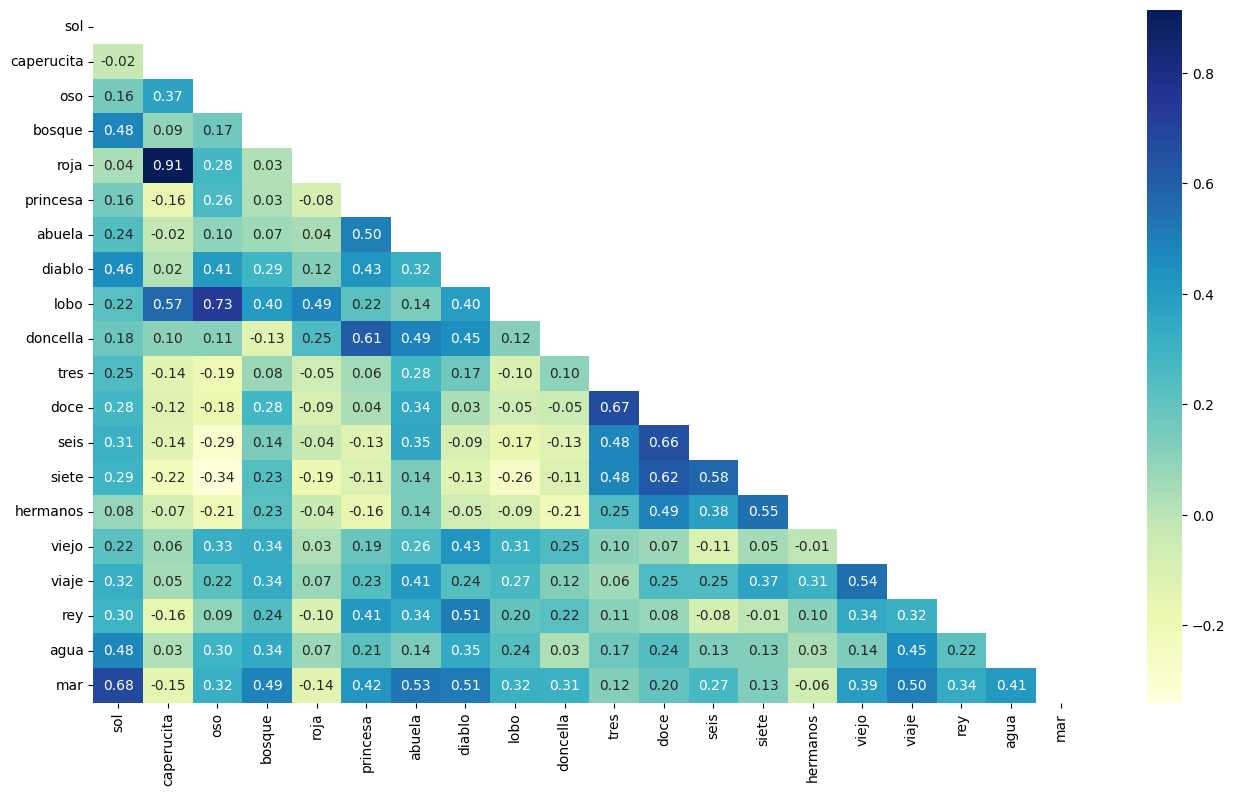

In [ ]:
 embeddings_matrix_distance_word2vec(model_1, words)

Se observan algunas relaciones interesantes que el modelo ha conseguido aprender.
Por ejemplo, viendo lo colores más intensos que implican mayor similitud, se observa:
* "caperucita" - "roja" - "lobo" (relación claramente aprendida del  popular cuento de "Caperucita roja".)
* "tres" - "doce" - "seis" - "siete" (zona que sugiere que el modelo ha aprendido relaciones entre los números)
* "princesa" - "doncella" (sugiere que el modelo aprendió sinónimos o palabras con significados que pueden estar relacionados)

In [ ]:
# Graficar los embedddings en 2D - Las 150 palabras más frecuentes

MAX_WORDS = 150
top_words = model_1.wv.index_to_key[:MAX_WORDS]

# Obtener los vectores de las palabras más frecuentes
vecs = np.array([model_1.wv[word] for word in top_words])

# Reducir la dimensionalidad a 2D usando t-SNE
tsne_2 = TSNE(n_components=2, random_state=0)
reduced_vecs_2d = tsne_2.fit_transform(vecs)

# Graficar
fig = px.scatter(x=reduced_vecs_2d[:, 0], y=reduced_vecs_2d[:, 1], text=top_words)
fig.update_traces(textposition='top center')
fig.update_layout(title="T-SNE Embeddings de las 150 palabras más frecuentes",
                  xaxis_title="Componente 1",
                  yaxis_title="Componente 2")
fig.show(renderer="colab")

In [ ]:
# Graficar los embedddings en 3D - Las 150 palabras más frecuentes

tsne_3 = TSNE(n_components=3, random_state=0)
reduced_vecs_3d = tsne_3.fit_transform(vecs)

# Graficar
fig = px.scatter_3d(x=reduced_vecs_3d[:, 0], y=reduced_vecs_3d[:, 1], z=reduced_vecs_3d[:, 2], text=top_words)

# Personalización del gráfico
fig.update_traces(marker=dict(size=5, opacity=0.5, line=dict(width=0.5, color='DarkSlateGrey')),
                  textposition='top center')
fig.update_layout(title="T-SNE - Embeddings de las 150 palabras más frecuentes",
                  scene=dict(
                      xaxis_title='Componente 1',
                      yaxis_title='Componente 2',
                      zaxis_title='Componente 3'
                  ))
fig.show(renderer="colab")

Tensorflow [Embedding Projector ](https://projector.tensorflow.org/)

In [ ]:
# Guardar los vectores y labels como tsv para graficar en http://projector.tensorflow.org/
vectors = np.asarray(model_1.wv.vectors)
labels = list(model_1.wv.index_to_key)

np.savetxt("model_vectors.tsv", vectors, delimiter="\t")

with open("model_labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)

Tomo las 200 palabras más cercanas a las 20 seleccionadas:

In [ ]:
# Lista de palabras más similares a las palabras clave
selected_words = []
for keyword in words:
    similar_words = model_1.wv.most_similar(keyword, topn=200)
    selected_words.extend([w[0] for w in similar_words])

selected_words = list(set(selected_words))  # Elimina duplicados

# Obtener los vectores de las palabras seleccionadas
sampled_vectors = np.array([model_1.wv[word] for word in selected_words])

# Guardar los vectores y etiquetas seleccionadas para la visualización en TensorFlow Projector
np.savetxt("selected_vectors.tsv", sampled_vectors, delimiter="\t")
with open("selected_labels.tsv", "w") as f:
    for word in selected_words:
        f.write(f"{word}\n")


Con la ayuda del embedding proyector exploré los vectores con T-SNE, PCA y UMAP.

Se observan algunos ejemplos de conceptos con cercanía correctamente identificada en función del contexto de este corpus:

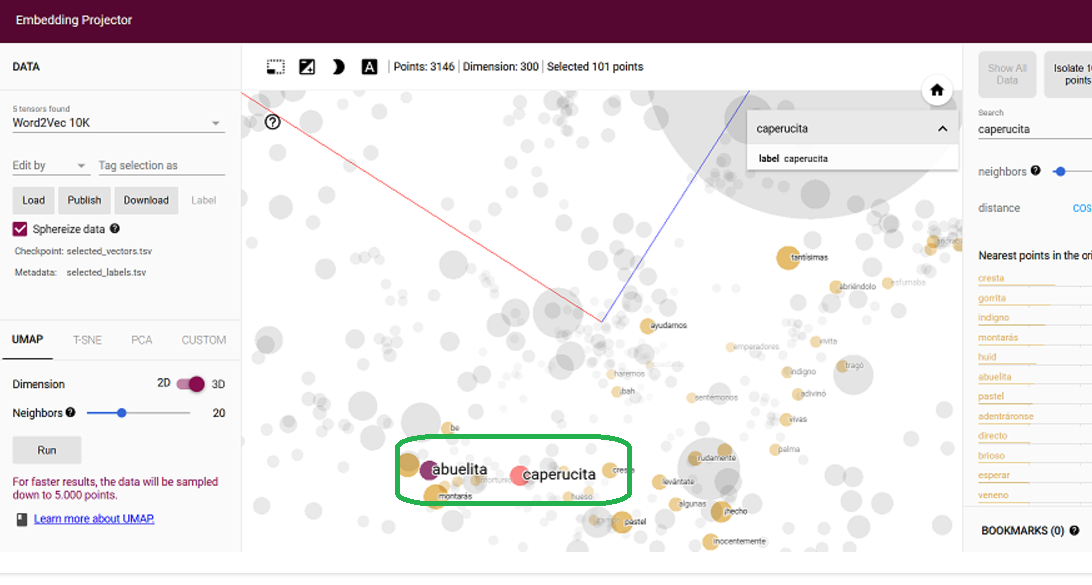

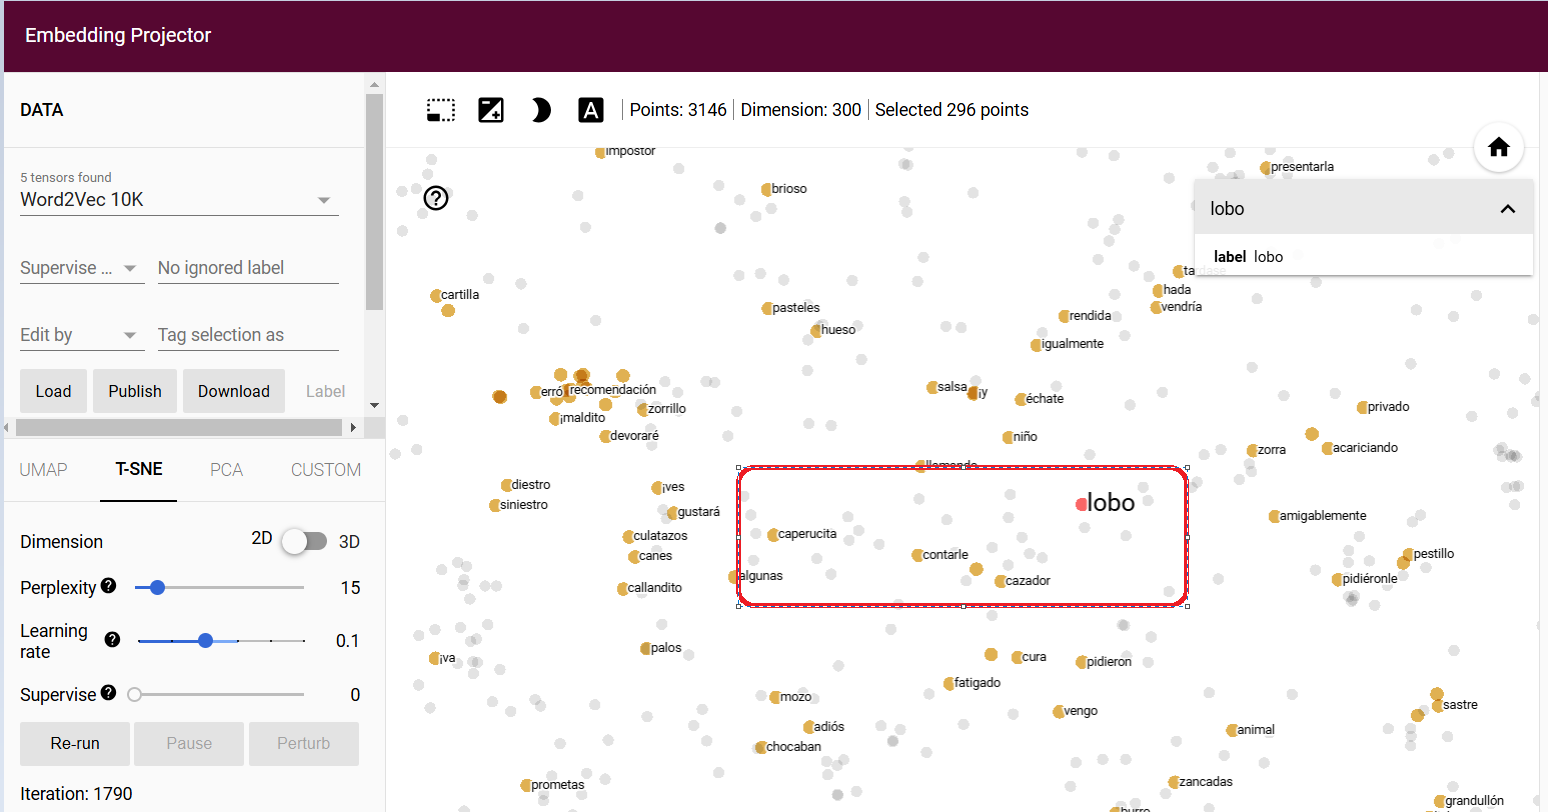

#### Conclusión final

El entrenamiento de embeddings de palabras utilizando Word2Vec permite representar semánticamente el vocabulario de un corpus de texto en un espacio vectorial denso, donde palabras con significados similares están ubicadas cerca unas de otras.   
<br>
Sin embargo, los resultados obtenidos al entrenar el modelo dependerán en gran medida de dos factores clave:
* el corpus de texto utilizado.
* los parámetros de entrenamiento elegidos.  

<br>


El corpus de texto es fundamental, ya que Word2Vec genera embeddings que capturan las relaciones y patrones semánticos presentes en los datos de entrada.   
El tamaño, la calidad y la naturaleza del corpus influirán directamente en la calidad de los embeddings generados.  
<br>

Si el corpus está especializado en un dominio (por ejemplo, en este caso, cuentos infantiles), los embeddings generados estarán mejor adaptados para tareas específicas dentro de ese dominio.  

La generalización fuera de este dominio resultará ser menos precisa, porque es posible que los embeddings no capten relaciones más generales entre palabras que no están específicamente representadas en el corpus.  
<br>

Para obtener buenos resultados, también es necesario considerar los parámetros de entrenamiento (tamaño de la ventana, número de épocas, tamaño del vector, etc.), ya que, como se observa en la comparación de modelos entrenados con diferentes parámetros, los resultados varían y, por lo tanto, los parámetros deben ser ajustados de forma tal que se eviten problemas como el sobreajuste o la falta de generalización, y que los embeddings sean en efecto útiles para el propósito para el cual fueron entrenados.